<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
       Online Shoppers Purchasing Intention dataset
    </h1></td>
    <td width="30%">
    <div style="text-align: right">
    <br> Homework - Machine Learning 2023</br> 
    <br> Irene Majer </br>
    <br> 10870730 </br>
    </div>
    </td>
 </tr>
 </table>

This dataset contains information on the browsing behavior and purchase history of online shoppers. The dataset contains different sessions, and it was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.
Here the main step of the analysis: 
- Preliminary analysis (in particular Exit Rate, see note)
- Classification model to correctly predict if an online shopper is likely to perform a purchase
- Clustering based method; compare the performance with respect to the best classification model

*Note: in this analysis I'm using some parts of the code implemented during the ML laboratories*

### Note 
A significant amount of Exit Rate sample are corrupted. To recover data loss, I need to train a regressor to predict the value of this variable.
Exit Rate is also missing in the test set, so I will use only the training data for this step and a robust evaluation techniques to compare algorithms.

# Table of contents

1. [**Loading data and Data Exploration**](#section_1)
2. [**Missing values in ExitRates**](#section_2)
3. [**Classification**](#section_3)
3. [**Clustering**](#section_4)

### Libraries 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
    
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import random
import warnings


<a id='section_1'></a>
# 1. Loading data and Data Exploration <a name="First"></a>
The dataset consists of feature vectors belonging to 12,330 sessions, splitted between training and test.
The dataset consists of 10 numerical and 8 categorical attributes.
The 'Revenue' attribute can be used as the class label.

The numeric variables are:
- `Administrative`: Number of pages visited by the visitor about account management
- `Administrative Duration`: Total amount of time (in seconds) spent by the visitor on account management related pages
- `Informational`: Number of pages visited by the visitor about Web site, communication and address information of the shopping site
- `Informational Duration`: Total amount of time (in seconds) spent by the visitor on informational pages
- `Product Related`: Number of pages visited by visitor about product related pages
- `Product-Related Duration`: Total amount of time (in seconds) spent by the visitor on product related pages
- `Bounce Rate`: Average bounce rate value of the pages visited by the visitor
- `Exit Rate`: Average exit rate value of the pages visited by the visitor
- `Page Value`: Average page value of the pages visited by the visitor
- `Special Day`: Closeness of the site visiting time to a special day

The categorical variables are:
- `Operating system`: Operating system of the visitor
- `Browser`: Browser of the visitor
- `Region`: Geographic region from which the session has been started by the visitor
- `Traffic type`: Traffic source by which the visitor has arrived at the Web site (e.g., banner, SMS, direct)
- `Visitor type`: Whether the visitor is a New Visitor, a Returning Visitor or Other
- `Weekend`: Whether the date of the visit is weekend
- `Month`: Month of the visit
- `Revenue`: Whether the visit has been finalized with a transaction

In [2]:
# Read the training dataset 
train_data = pd.read_csv("data/training_set_online_shoppers_intention.csv")
train_data.info()
train_data.drop("Unnamed: 0", axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9248 entries, 0 to 9247
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               9248 non-null   int64  
 1   Administrative           9248 non-null   int64  
 2   Administrative_Duration  9248 non-null   float64
 3   Informational            9248 non-null   int64  
 4   Informational_Duration   9248 non-null   float64
 5   ProductRelated           9248 non-null   int64  
 6   ProductRelated_Duration  9248 non-null   float64
 7   BounceRates              9248 non-null   float64
 8   ExitRates                6466 non-null   float64
 9   PageValues               9248 non-null   float64
 10  SpecialDay               9248 non-null   float64
 11  Month                    9248 non-null   object 
 12  OperatingSystems         9248 non-null   int64  
 13  Browser                  9248 non-null   int64  
 14  Region                  

Here a short summary of the results:
- Sample in training set: 9284
- Sample in training ExitRates: 6466, the only with null value
- Different dtypes: bool(2), float64(7), int64(8), object(2)


In [3]:
# Loading the test dataset 
test_data = pd.read_csv("data/test_set_online_shoppers_intention.csv")
test_data.info()
test_data.drop("Unnamed: 0", axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3082 entries, 0 to 3081
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               3082 non-null   int64  
 1   Administrative           3082 non-null   int64  
 2   Administrative_Duration  3082 non-null   float64
 3   Informational            3082 non-null   int64  
 4   Informational_Duration   3082 non-null   float64
 5   ProductRelated           3082 non-null   int64  
 6   ProductRelated_Duration  3082 non-null   float64
 7   BounceRates              3082 non-null   float64
 8   ExitRates                2165 non-null   float64
 9   PageValues               3082 non-null   float64
 10  SpecialDay               3082 non-null   float64
 11  Month                    3082 non-null   object 
 12  OperatingSystems         3082 non-null   int64  
 13  Browser                  3082 non-null   int64  
 14  Region                  

I will use only the training data for this step and we will perform robust evaluation techniques to compare algorithms and chose the best to fill the missing values. 

## Revenue count
The first step is plotting the data to have a better idea of the dataset. The output variable is `Revenue` -> a binary feature that indicates whether the visitor made a purchase or not. 

In [4]:
train_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.0,5,19.000000,0.000000,0.080000,0.000000,0.6,May,2,2,1,3,Returning_Visitor,False,False
1,5,158.700000,0,0.0,51,1364.266667,0.007692,0.011987,0.000000,0.0,Nov,3,2,3,2,Returning_Visitor,True,False
2,7,87.916667,1,0.0,46,1621.025379,0.004082,0.020544,6.023523,0.0,Dec,1,1,3,2,Returning_Visitor,False,False
3,1,4.000000,0,0.0,37,1296.942857,0.013889,NaN,0.000000,0.8,May,2,2,4,2,Returning_Visitor,False,False
4,2,132.400000,0,0.0,11,296.300000,0.000000,NaN,0.000000,0.0,Sep,2,4,3,2,New_Visitor,False,False


7807


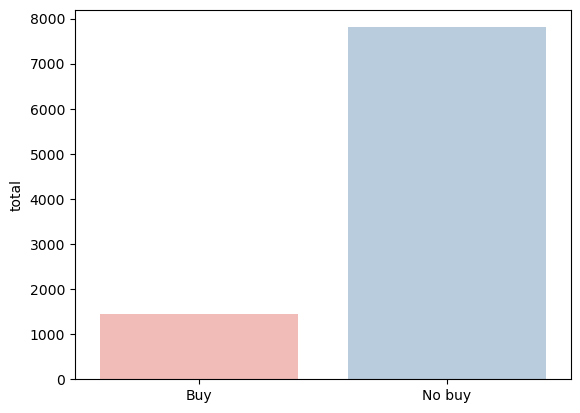

In [5]:
#plotting the number of samples that buy vs 
true_count = (train_data['Revenue'] == True).sum()
false_count = (train_data['Revenue'] == False).sum()
print(false_count)

revenue = pd.DataFrame({'Buy':[true_count], 'No buy':[false_count]}, index = ['total']).T
_ = sns.barplot(x = ['Buy', 'No buy'], y = "total", data = revenue , palette="Pastel1")

Most of the customers didn't complete the purchase. This is quite normal for the majority of the ecommerce since they receive many visits, but most of them don't end with a purchase (i.e: you visit an ecommerce because you are bored). This could be a bias in the further analysis -> **this dataset is unbalanced** because we have 15% of the cases that puchase something, while the 85% that didn't buy any product. This may be a problem in the future analysis to making correct prediction. This because also a simple classifier can obtain good results just by predicting the most common outcome. Let's check in the test dataset: 

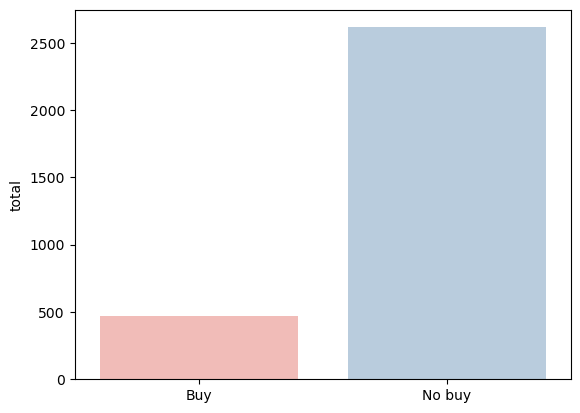

In [6]:
true_count = (test_data['Revenue'] == True).sum()
false_count = (test_data['Revenue'] == False).sum()

revenue = pd.DataFrame({'Buy':[true_count], 'No buy':[false_count]}, index = ['total']).T
_ = sns.barplot(x = ['Buy', 'No buy'], y = "total", data = revenue , palette="Pastel1")

The situation is the same in both dataset. Now we will check the other variables using the traning dataset.

## Time event variable
In case of categorical I need to use `value.counts()` or similar functions to understand if the classes are balanced.
We will start with time/event variable such as `Weekend`, `Month` and `Special Day` to understand if these can impact `Revenue` making.

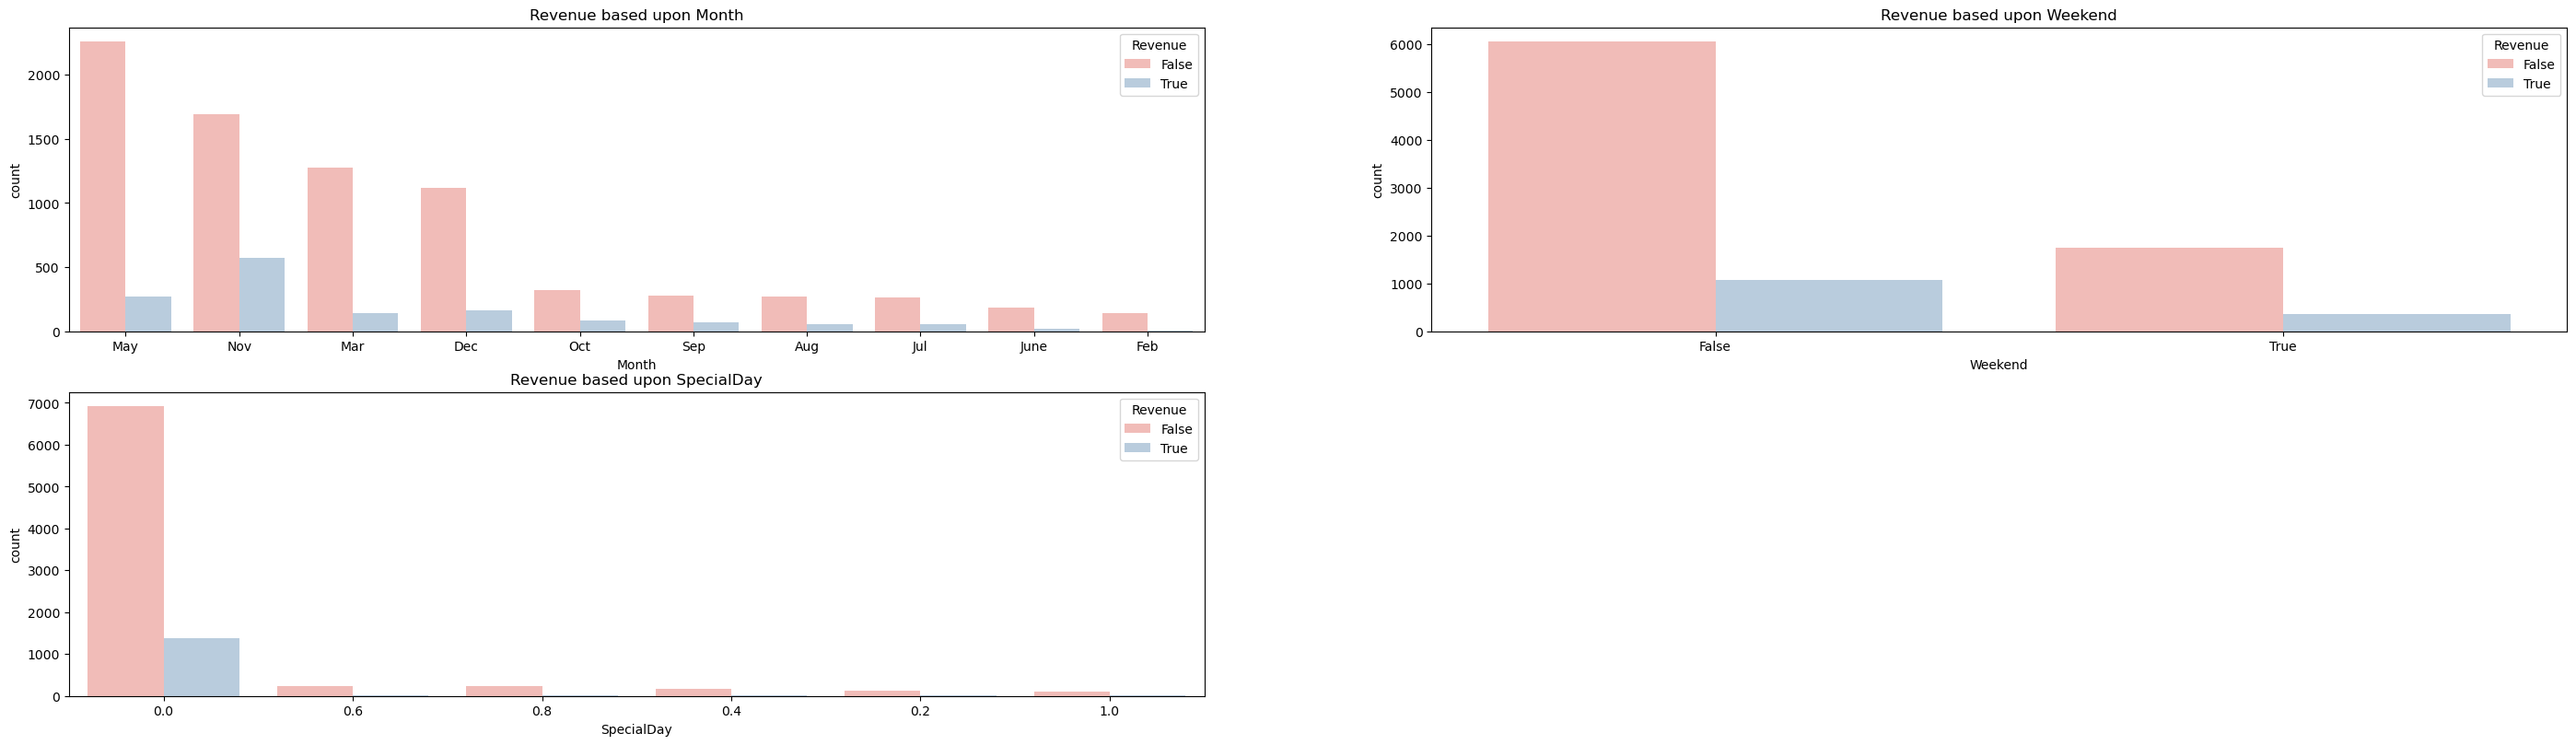

In [7]:
features =['Month','Weekend','SpecialDay']  
plt.figure(figsize=(35,30))
number = 0
for feature in features:
    number = number + 1
    ax = plt.subplot(6, 2, number,adjustable='datalim')
    sns.countplot(x=train_data[feature],hue=train_data['Revenue'],
                  order = train_data[feature].value_counts(ascending=False).index,  palette = "Pastel1")
    ax.set_title('Revenue based upon'+ " " + feature)
   

With this plot I can do some preliminary analysis :
- On March, May, November and December, we see the more online shopper visits, and there is no record for January and for April.
- More shopper visits without revenue than revenue -> we already know this
- There are more shopper visits with revenue made on non-weekends than weekends

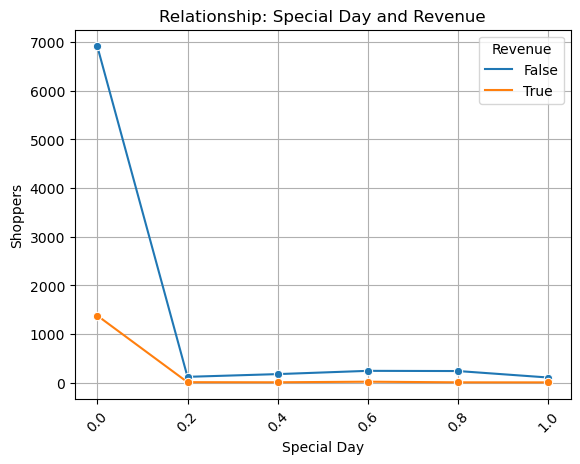

In [8]:
revenue_counts = train_data.groupby(['SpecialDay', 'Revenue']).size().reset_index(name='Count')

sns.lineplot(x='SpecialDay', y='Count', hue='Revenue', data=revenue_counts, marker='o')

plt.xlabel('Special Day')
plt.ylabel('Shoppers')
plt.title('Relationship: Special Day and Revenue')
plt.grid(True)  # Opzionale: mostra una griglia di riferimento

# Modifica le etichette dell'asse X
plt.xticks(rotation=45)

plt.show()

From the above graph, I can see that
- The majority of shoppers visit the website on Non-special day occasions
- There is a slight increase in visits around particular day index (from 0.2 to 0.6)
- There is a decrease from special day index = from 0.6 to 1

This is because one costumer want to buy a special gift without having delay in shipping.

## Visitor Type 

Let's check if the type of shoppers could have an impact on Revenue

Text(0.5, 1.0, 'Revenue based upon VisitorType')

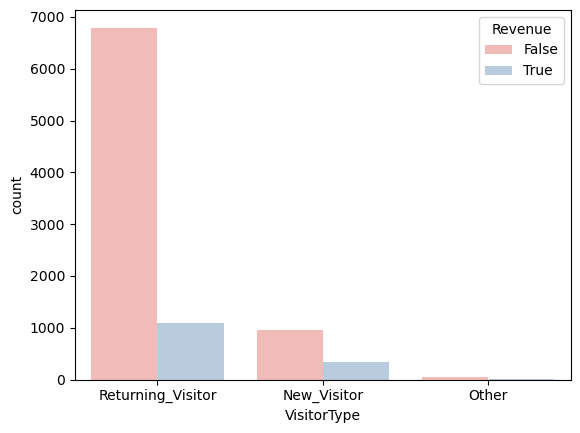

In [9]:
sns.countplot(x=train_data["VisitorType"],hue=train_data['Revenue'], palette = "Pastel1")
ax.set_title('Revenue based upon VisitorType')

It seemed that visitor type and revenue are not independent: returning visitors have the highest count, followed by new visitors, and visitors from Other category have the lowest count. In proportion new visitors make more purchase.

Now let's see the other categorical viariables:

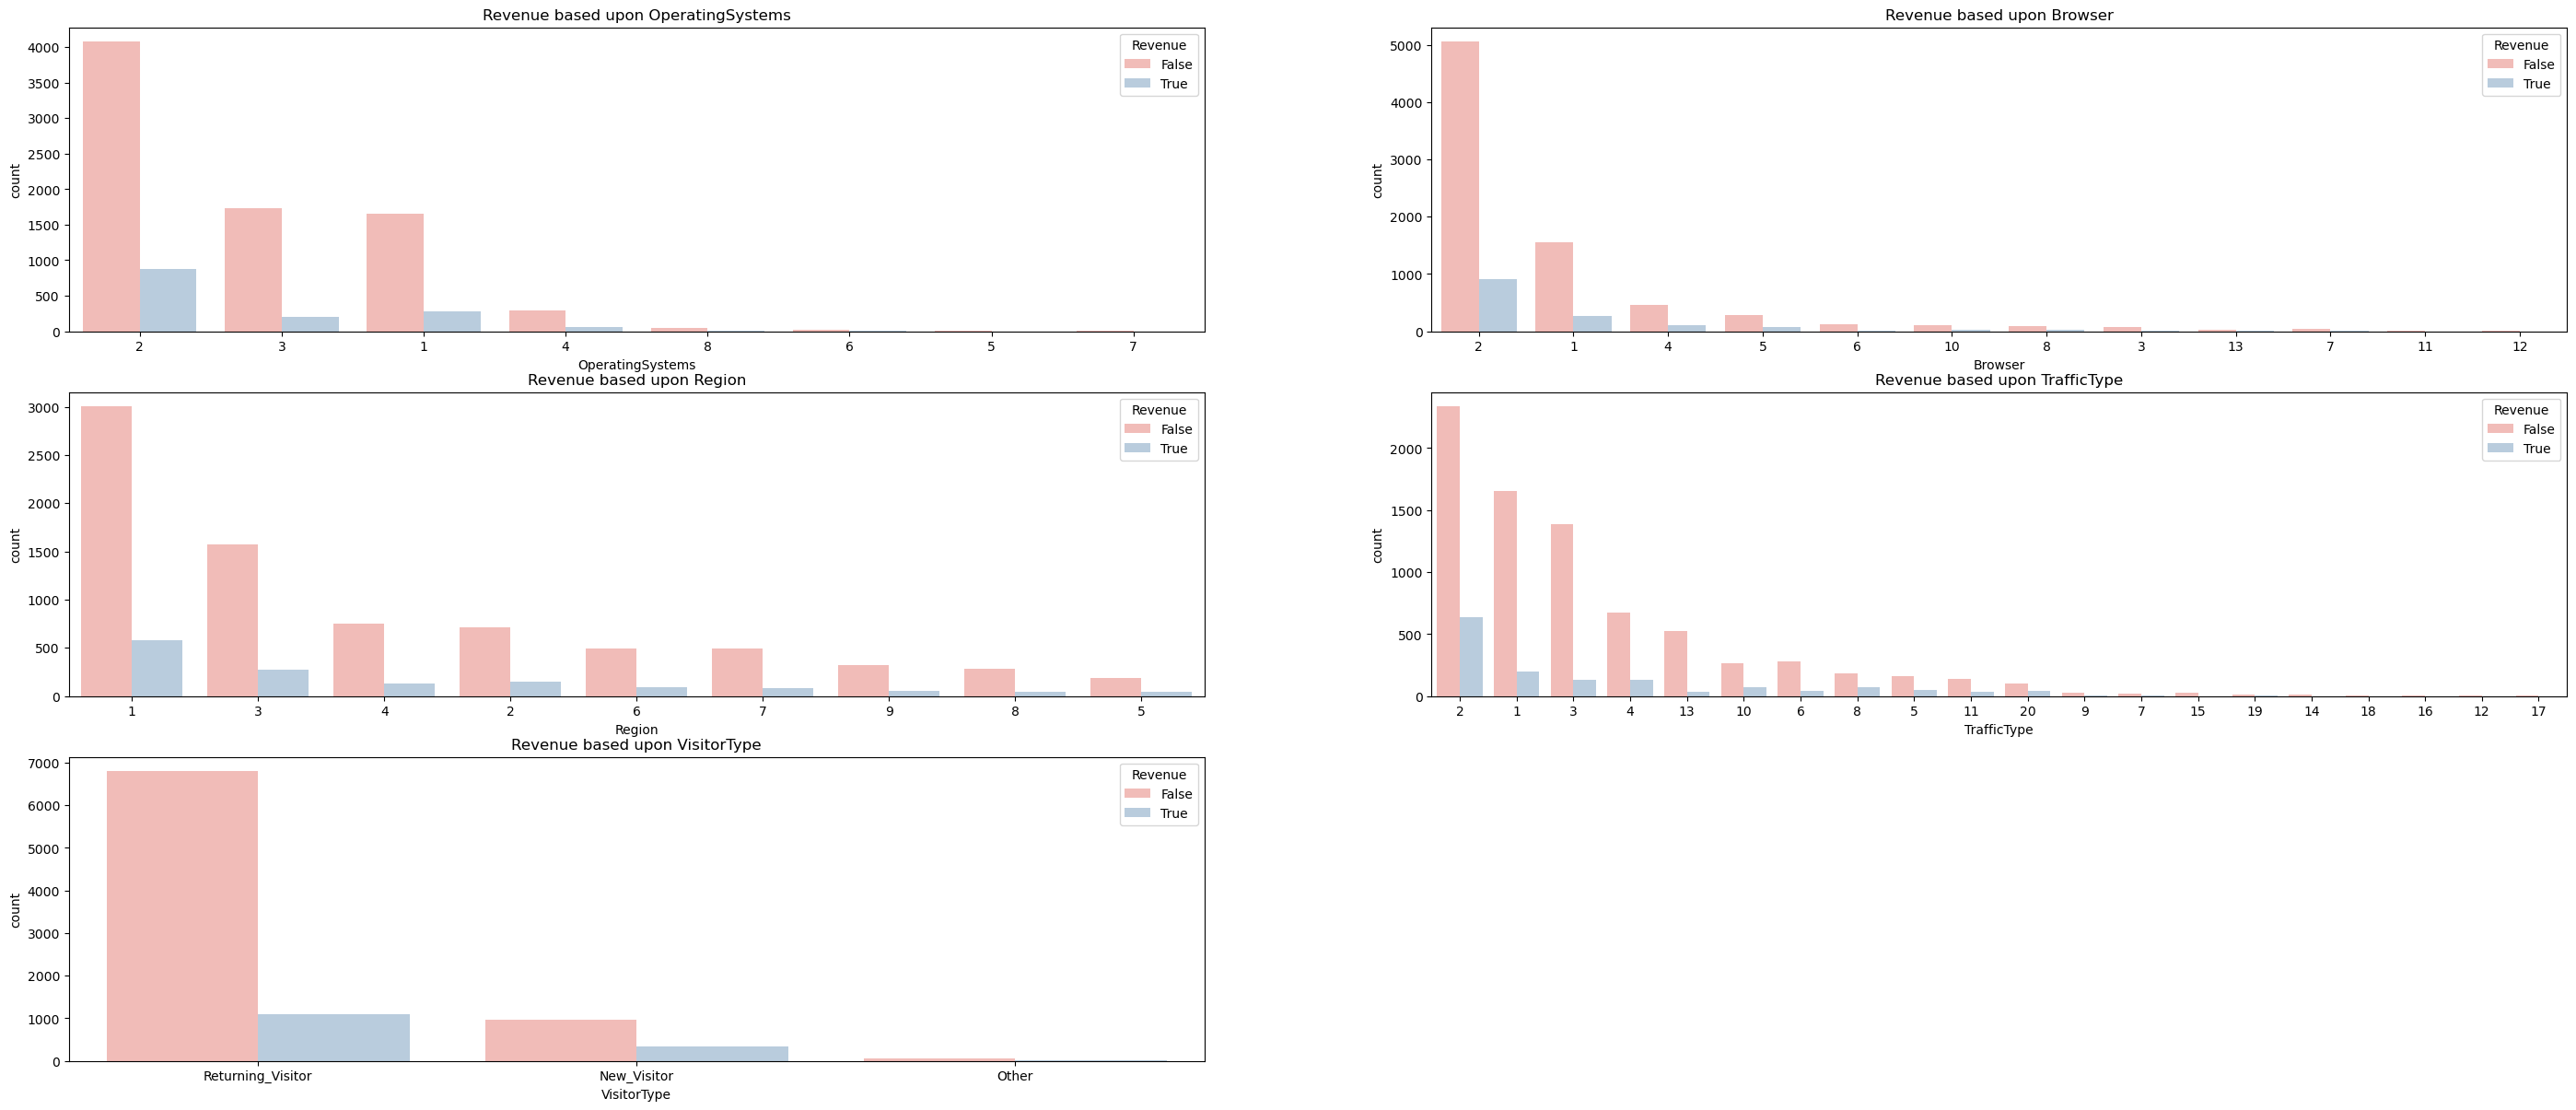

In [10]:
categorical=['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
 
plt.figure(figsize=(35,30))
number = 0
for category in categorical:
    number = number + 1
    ax = plt.subplot(6, 2, number,adjustable='datalim')
    sns.countplot(x=train_data[category],hue=train_data['Revenue'],
                  order = train_data[category].value_counts(ascending=False).index,  palette = "Pastel1")
    ax.set_title('Revenue based upon'+ " " + category)

There are some values of our categorical variable with very low count. We will merge them in the one-hot encoded function step. There seems to be a trend in the data: the first "categories" are those with the highest counts (both those who bought and those who didn't). This is quite misleading: The first categories probably contain the most used choices overall. For example, most people use windows and chrome, so obviously the corresponding values in OS and Browser are higher.

## Corelation between variables
Now I want to analyze all the variables together:

In [ ]:
sns.pairplot(train_data, hue='Revenue', height=2.5)

To be honest there are too many features in this dataset to use the pairplot to understand correlation. Let's try with an heatmap

<Axes: >

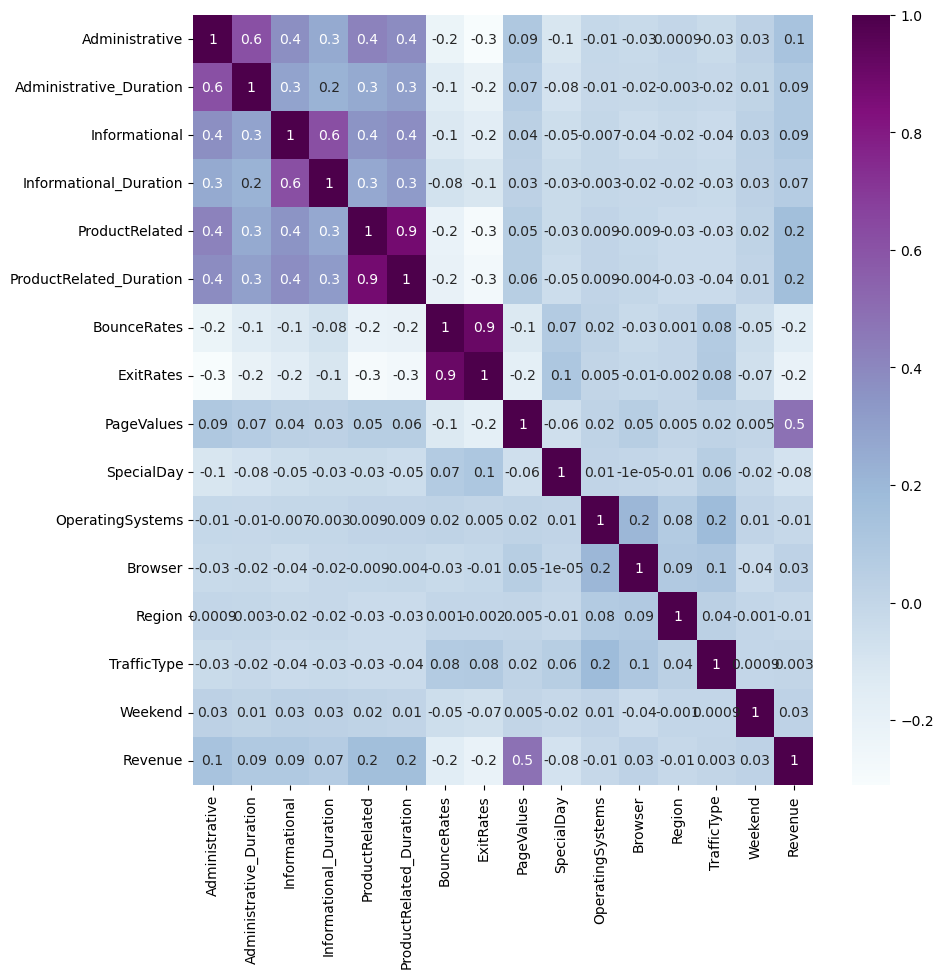

In [12]:
# bivariate correlations for all our columns
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(numeric_only = True),annot=True, fmt='.1g',cmap='BuPu')

I can say that:
- Revenue is highly positively correlated with the average number of PageValues feature
- Revenue is inversely correlated with Bounce and Exit Rates
- Certain attributes have very little correlation with the Revenue
- ExitRates is highly correlated with BounceRates
- The "administrative" variables are higly correlated to each other

This gives us an overall analysis, now we can go more in deep:

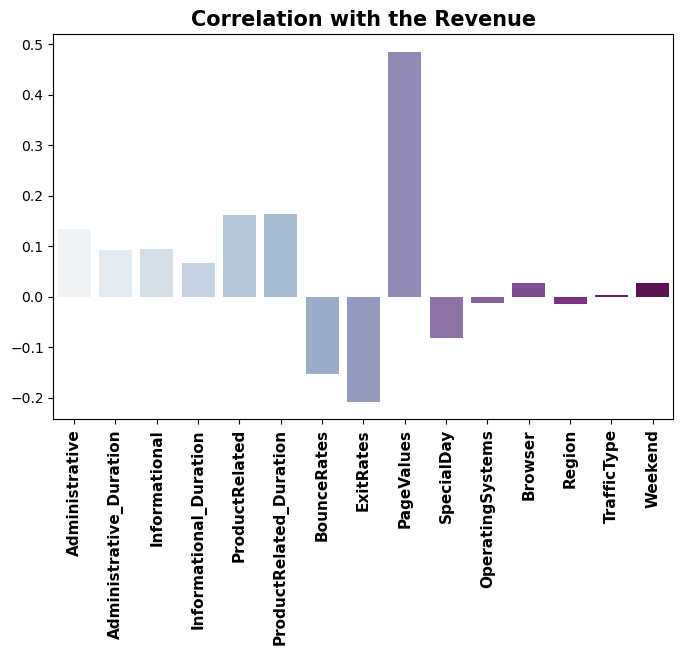

In [13]:
revenue_corr = train_data.corr(numeric_only = True)['Revenue'] 

#Setting up the plot
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = revenue_corr[:-1].index, y = revenue_corr[:-1].values, ax=ax,palette="BuPu")
plt.title('Correlation with the Revenue',fontweight='bold',size=15,color='black')
plt.xticks(rotation = 90,fontweight='bold',size=11,color='black')
plt.show()

PageValues has the higher correlation with Revenue.
> Page Value is the average value for a page that a user visited before landing on the goal page or completing an Ecommerce transaction (or both). This value is intended to give you an idea of which page in your site contributed more to your site's revenue. If the page wasn't involved in an ecommerce transaction for your website in any way, then the Page Value for that page will be 0 since the page was never visited in a session where a transaction occurred. - From Google Analytics

So therefore as page values increase, a sale should correspond.
Then I can find ProductRelated and ProductRelated_Duration, that is because if a costumer want to buy something, usually he will compare different brand for the same items, or different colors.

## Categorical values 
Before starting any other type of analysis I need to encode the categorical variables into numeric one. To do this I will use the one-hot encoded function. 

This confirms the previous result. Let's try to observe better the possible relationships

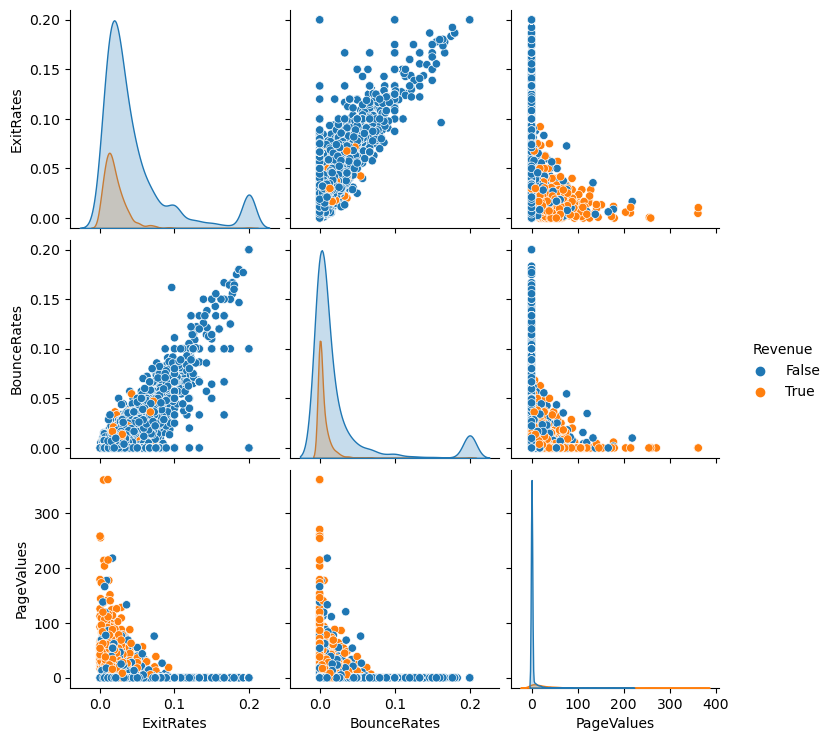

In [14]:
checkCorr = train_data[['ExitRates', 'BounceRates', 'PageValues', 'Revenue']]
sns.pairplot(checkCorr, hue='Revenue')


- BounceRate and ExitRate seems to be correlated. This because are both variable that represent a leaving visitors 
- There is a trend between PageValues and ExitRates. Higher value of PageValues are associated to lower probabilities of ExitRate. This because if a costumer want to buy something, usually he will compare different brand for the same items, or different colors. So the ExitREate in these cases is low.
- There is also a trend in PageValues and BounceRates. Maybe because a user could open the site just to check the price of an item and exit immediately after. 

Anyway it's clearly that higher values of PageValues are associated with a successful purchasing. While higher values of ExitRates and BouncRates result in failed purchasing.  

### Encoding 
The first step is to merge the categories with less counts into other in order to have less features at the end. I will set some threshold to decide where to cut to set the "Other" categories

In [15]:
#Check number to set a threshold
Browser = train_data['Browser'].value_counts() 
Operating_system = train_data['OperatingSystems'].value_counts()

In [16]:
def merge_rare_categories(dataframe, col, threshold=0.05, new_category_name='Others'):
    unique_values = dataframe[col].value_counts()
    threshold_value = threshold * len(dataframe)/100
    for value in unique_values.index:
        if unique_values[value] < threshold_value:
            dataframe.loc[dataframe[col] == value, col] = new_category_name
    return dataframe.head(10)

merge_rare_categories(train_data,"Browser",100)
merge_rare_categories(train_data,"OperatingSystems",20)
merge_rare_categories(train_data,"TrafficType",100)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.0,5,19.000000,0.000000,0.080000,0.000000,0.6,May,2,Others,1,Others,Returning_Visitor,False,False
1,5,158.700000,0,0.0,51,1364.266667,0.007692,0.011987,0.000000,0.0,Nov,3,Others,3,Others,Returning_Visitor,True,False
2,7,87.916667,1,0.0,46,1621.025379,0.004082,0.020544,6.023523,0.0,Dec,1,Others,3,Others,Returning_Visitor,False,False
3,1,4.000000,0,0.0,37,1296.942857,0.013889,NaN,0.000000,0.8,May,2,Others,4,Others,Returning_Visitor,False,False
4,2,132.400000,0,0.0,11,296.300000,0.000000,NaN,0.000000,0.0,Sep,2,Others,3,Others,New_Visitor,False,False
5,2,23.000000,0,0.0,39,1828.966667,0.005128,0.020085,20.592471,0.0,Nov,1,Others,1,Others,Returning_Visitor,True,True
6,0,0.000000,2,23.0,52,4167.488095,0.009615,NaN,0.000000,0.0,May,2,Others,3,Others,Returning_Visitor,False,False
7,1,5.000000,1,292.0,35,1916.900000,0.000000,0.015556,11.191893,0.2,May,2,Others,6,Others,Returning_Visitor,False,True
8,1,5.000000,0,0.0,29,3441.439286,0.007143,NaN,0.000000,0.0,Dec,3,Others,8,Others,Returning_Visitor,False,False
9,0,0.000000,0,0.0,4,149.000000,0.000000,0.050000,0.000000,0.0,Mar,2,Others,1,Others,Returning_Visitor,False,False


Now we can do the one-hot encoded on the categorical variables

In [17]:
categorical_columns = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType']
train_enc = pd.get_dummies(train_data[categorical_columns].astype(str))
train_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.0,5,19.000000,0.000000,0.080000,0.000000,0.6,May,2,Others,1,Others,Returning_Visitor,False,False
1,5,158.700000,0,0.0,51,1364.266667,0.007692,0.011987,0.000000,0.0,Nov,3,Others,3,Others,Returning_Visitor,True,False
2,7,87.916667,1,0.0,46,1621.025379,0.004082,0.020544,6.023523,0.0,Dec,1,Others,3,Others,Returning_Visitor,False,False
3,1,4.000000,0,0.0,37,1296.942857,0.013889,NaN,0.000000,0.8,May,2,Others,4,Others,Returning_Visitor,False,False
4,2,132.400000,0,0.0,11,296.300000,0.000000,NaN,0.000000,0.0,Sep,2,Others,3,Others,New_Visitor,False,False


In [18]:
train_data = train_data.drop(categorical_columns, axis=1) 
train_data = pd.concat([train_data, train_enc], axis=1)

Since Weekend and Revenue are boolean, I convert them into int for convenience

In [19]:
train_data['Revenue'] = train_data['Revenue'].astype(int)
train_data['Weekend'] = train_data['Weekend'].astype(int)
train_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_Others,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.000000,0,0.0,5,19.000000,0.000000,0.080000,0.000000,0.6,...,0,0,0,0,0,0,1,0,0,1
1,5,158.700000,0,0.0,51,1364.266667,0.007692,0.011987,0.000000,0.0,...,0,0,0,0,0,0,1,0,0,1
2,7,87.916667,1,0.0,46,1621.025379,0.004082,0.020544,6.023523,0.0,...,0,0,0,0,0,0,1,0,0,1
3,1,4.000000,0,0.0,37,1296.942857,0.013889,NaN,0.000000,0.8,...,1,0,0,0,0,0,1,0,0,1
4,2,132.400000,0,0.0,11,296.300000,0.000000,NaN,0.000000,0.0,...,0,0,0,0,0,0,1,1,0,0


### Note
We will repeat this step for the test dataset

<a id='section_2'></a>
# 2. Missing values in ExitRates
Now I'm going to deal with the data loss in the ExitRates variable with different approach

- Linear regression
- Polynomial regression
- Ridge regression
- Lasso regression

This imputation method uses available information to fill in missing data, resulting in fixed imputed values. Therefore, the imputed values depend entirely on the values of all other features, leading to consistent outcomes. However, this approach does not account for random error.

I need to split the dataset:
- noNan is the original dataset without NaN values for ExitRates
- TestNan is the subset of the original dataset where ExitRates is null

At the end of the analysis we will apply the best model found and impute the value obtained into the original dataset. 

## Linear regression
$\begin{equation*}Y=\beta_0+\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p + \epsilon\end{equation*}$


In [20]:
#Train and test 
noNan = train_data.dropna(subset=['ExitRates'])
testNaN = train_data[train_data['ExitRates'].isnull()]

X = noNan.drop('ExitRates', axis=1)
y = noNan['ExitRates']
print(X.shape, y.shape)

(6466, 39) (6466,)


In [21]:
#Greedy code to extract features 
features = noNan.drop('ExitRates', axis=1)
X_all_features = features.columns.tolist()
X_all_features

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'PageValues',
 'SpecialDay',
 'Weekend',
 'Revenue',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'OperatingSystems_1',
 'OperatingSystems_2',
 'OperatingSystems_3',
 'OperatingSystems_Others',
 'Browser_Others',
 'Region_1',
 'Region_2',
 'Region_3',
 'Region_4',
 'Region_5',
 'Region_6',
 'Region_7',
 'Region_8',
 'Region_9',
 'TrafficType_Others',
 'VisitorType_New_Visitor',
 'VisitorType_Other',
 'VisitorType_Returning_Visitor']

The train dataset contains 6466 rows while the test contains 2782.

I'm including the class variable `Revenue` even if this might be seen as contradictory because we will use the imputed values to predict if a costumer will make a purchase or not. Anyway, excluding this variable would leads to inaccurate result.

We split the Train dataset (the one without NaN) into train and test to do cross validation:

In [22]:
#Split Train (no NaN)
from sklearn.model_selection import train_test_split

size = 0.3
seed = 40

# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

X_train.shape  (4526, 39)
X_test.shape  (1940, 39)


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Fit the LinearRegression predictor
model = LinearRegression(fit_intercept=True) # 1- hyperparams selection
model = model.fit(X_train, y_train)          # 2- model fitting
y_predict_test = model.predict(X_test)       # 3- prediction
y_predict_train = model.predict(X_train)


print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.8698067735550594
Train MSE score  0.0003055857072015265
Test R2 score  0.8408023536542771
Test MSE score  0.00035892114062412736


The values of $R^2$ are quite high for both train and test and are quite similar. So the model with all the feature represent quite well the relationship. Note that MSE scores for both test and train are very low. Now let's give a look to the F-test, t-test and coefficient of the Linear model. 

In [24]:
from scipy.stats import t, f

def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def tss(y):
    return np.sum((y - y.mean()) ** 2)

def multiple_least_squares(X, y):
    # Helper function that uses scikit-learn models
    # and behaves as the function we implemented in
    # Lab02.01
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred

# Computes coefficient statistcs
def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features
    
    # If the ones column has not been added
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    
    # Compute the prediction
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE = ((y-pred)**2).sum()/(n_samples - n_features)

    # Compute the t statistics
    se2_b = RSE*(np.linalg.inv(np.dot(X.T, X)).diagonal())
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b

    # Compute the p-value
    p_values = np.array([2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]
    #print("RSS: {}".format(RSS))
    
    return df
 
# H0: all features in the subset are equal to 0    
def Ftest_restricted(data, y, subset_features):
    # Train the complete model
    X_complete = data.to_numpy()
    y = y.to_numpy()
    n = X_complete.shape[0]
    
    betas_complete, y_pred = multiple_least_squares(X_complete, y)    
    rss_complete = rss(y, y_pred)
    nf_complete = X_complete.shape[1]
    
    # Train the restricted model
    notS = data.columns.difference(subset_features)
    X_restr = data[notS].to_numpy()
    betas_restr, y_pred = multiple_least_squares(X_restr, y)

    rss_restr = rss(y, y_pred)
    nf_restr = X_restr.shape[1]

    q = nf_complete - nf_restr

    # Compute F statistics
    F_num = (rss_restr - rss_complete) / q
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den

    # Compute the p-value
    p_value = f.sf(F, q, n - nf_complete - 1)
    return p_value, F

The next step is to check the values of Coefficient, t-stat and p-value to have a better idea of the model:

In [25]:
betas = np.array([model.intercept_, *model.coef_]).reshape(-1, 1)
warnings.filterwarnings("ignore", category=RuntimeWarning)
show_stats(X_train.to_numpy(), y_train.to_numpy(), betas, ['Intercept', *X_all_features], alpha=0.001)
#warnings.filterwarnings("default", category=RuntimeWarning)

,Name,Coefficients,Standard Errors,t-stat,p-value,reject H0
0,Intercept,2.903493e-02,NaN,NaN,NaN,False
1,Administrative,-9.663580e-04,1.106386e-04,-8.734364e+00,3.404957e-18,True
2,Administrative_Duration,-1.495394e-06,1.918332e-06,-7.795286e-01,4.357095e-01,False
3,Informational,4.117131e-05,2.853160e-04,1.443008e-01,8.852694e-01,False
4,Informational_Duration,-1.523539e-06,2.482478e-06,-6.137171e-01,5.394334e-01,False
5,ProductRelated,-1.090720e-04,1.263065e-05,-8.635501e+00,8.009043e-18,True
6,ProductRelated_Duration,2.846169e-07,3.138687e-07,9.068025e-01,3.645599e-01,False
7,BounceRates,8.686886e-01,5.794157e-03,1.499249e+02,0.000000e+00,True
8,PageValues,-1.092839e-04,1.666314e-05,-6.558424e+00,6.052968e-11,True
9,SpecialDay,5.982495e-03,1.527682e-03,3.916061e+00,9.134423e-05,True


The dataset is composed by both categorical and numerical variables. Sothere are some NaN values for the statistics since the one-hot encoding having a lot of 0 and some 1. I can start to notice some interesting facts:
- BounceRates have an high positive coefficient so higher values of this variables means higher values for ExitRates
- This is also the case for Special Day 
- There are some variables which have a negative effect on ExitRate such as PaveValues and, of course, Revenue.
- A lot of coefficients are not significanlty different from 0

The t-test for some features failed, meaning that we had not enough statistical evidence to reject the null hypothesis (we have no evidence to say that these features, alone, are correlated with the observation). 
However the t-statistic is not not entirely satisfactory:
- It is unclear how to make a single prediction of sales given the three advertising media budgets, since each of the budgets is associated with a separate regression equation
- Each of the three regression equations ignores the other two media in forming estimates for the regression coefficients.
- If input are highly correlated, using independent estimates can be misleading

In the multiple regression setting with $p$ predictors, we need to ask whether all of the regression coefficient are 0. To do so we use f-statistic -> is different from t-test because we are generalizing in a set with multiple parameters. In addition, even if $R^2$ is quite good, we can't take this model as a good one: it's a way too complex and the interpretability suffers a lot. 

Now let's see the F-statistic for the numerical variables in the dataset

In [26]:
alpha = 0.001

features = X_all_features[:38]
p_value, F = Ftest_restricted(X_train, y_train, features)
print("p-value =", p_value)
print("F-stat =", F)
if p_value < alpha:
    print("Reject H0: There evidence to say that at least one of the S features is useful")
else:
    print("Do not Reject H0: There is NO evidence to say that at least one of the S features is useful")

p-value = 0.0
F-stat = 760.6915690039265
Reject H0: There evidence to say that at least one of the S features is useful


The large F-statistic suggest that almost the majority of the variables are useful for the model. Note what happen if you restrict the model to the fist 9 numerical variables:

In [27]:
features = X_all_features[:12]
p_value, F = Ftest_restricted(X_train, y_train, features)
print("p-value =", p_value)
print("F-stat =", F)
if p_value < alpha:
    print("Reject H0: There evidence to say that at least one of the S features is useful")
else:
    print("Do not Reject H0: There is NO evidence to say that at least one of the S features is useful")

p-value = 0.0
F-stat = 2296.818287217606
Reject H0: There evidence to say that at least one of the S features is useful


The F-statistic increases a lot, the numerical variable are very useful to predict the values for ExitRates. Also the one-hot encoding may gives messy results.

## Polynomial regression

$\hat{y} = w_0 + w_1 x_1 + w_2 x_2$

I obtained good result with the Multivariate Linear Regression. Let's see if we can improve the result using other strategies. The first way is to use Polynomial Regression to see if there are some synergies or non linear relationship:

In [28]:
from sklearn.preprocessing import PolynomialFeatures

# Transform each feature into polynomial features based on the degree.
# Eg: in case of degree 2 we have the original features plus the product
# of each pair of features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly = poly.fit(X_train)

# Applies the transformation
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the LinearRegression predictor
model = LinearRegression(fit_intercept=True)           
model.fit(X_train_poly, y_train)
y_predict = model.predict(X_test_poly)

from sklearn.metrics import r2_score, mean_squared_error
print("Test R2 score ", r2_score(y_test, y_predict))
print("Test MSE score ", mean_squared_error(y_test, y_predict))

Test R2 score  0.8176708424148961
Test MSE score  0.00041107259253924235


I get a lower result for $R^2$  with respect to the simple linear model -> Let's check for other Polinomial Regression with different value for degree.
The first step is to create a new train + validation set: 

In [29]:
X_trainR, X_val, y_trainR, y_val = train_test_split(X_train, y_train, test_size=y_test.shape[0] 
                                                          ,random_state=seed)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

degree = list(range(1,4))
test_scores = np.zeros(len(degree))
val_scores = np.zeros(len(degree))
train_scores = np.zeros(len(degree))

r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Validation
for i, d in enumerate(degree):
    
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    
    model = model.fit(X_trainR, y_trainR)
    
    y_predict = model.predict(X_val)
    val_score = r2_score(y_val, y_predict)
    y_predict = model.predict(X_test)
    test_score = r2_score(y_test, y_predict)
    y_predict = model.predict(X_trainR)
    train_score = r2_score(y_trainR, y_predict)
    
    val_scores[i] = val_score
    test_scores[i] = test_score
    train_scores[i] = train_score

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)

# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_trainR]), np.concatenate([y_trainR]))
                                                             
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

Best degree:  1 
Val score:  0.8707922641774997
Test score: 0.8404309179903471


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


So the best degree is 1 that is the linear regression. Let's check the graph:

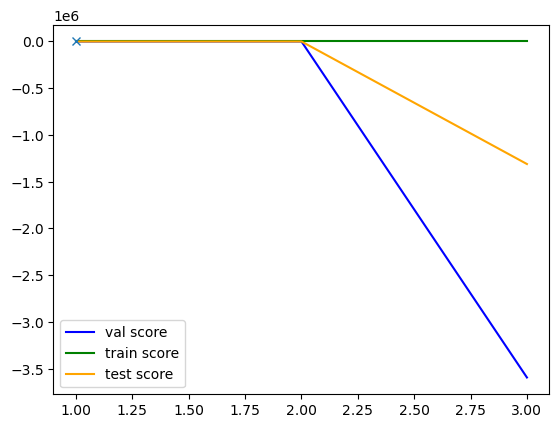

In [31]:
_ = plt.plot(degree,val_scores, label="val score", color="blue")
_ = plt.plot(degree, train_scores, label="train score", color="g")
_ = plt.plot(degree, test_scores, label="test score", color="orange")
_ = plt.plot([best_degree], [best_val_score], marker="x")
plt.legend()

The best result for every set is 1, that is the linear regression. You can also plot the graph qith a rage between 1 and 3 to notice that the best grade is 1. Using higher grade means overfitting in our case and this results also demonstrate the data don't contain paricular synergies effect. We count just a bunch of variable that are higly correlated and this probably don't affect the model too much.

### Adding Cross Validation

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,4))}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=3, refit=True, n_jobs=-1)
cv.fit(X_trainR, y_trainR)
model = cv.best_estimator_
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train score:", cv.best_score_)
print("Test score:", test_score)

Best degree: 1
Train score: 0.8605123224114228
Test score: 0.8404309179903471


So the best model remains Linear Regression

## Forward Stepwise Selection
Till now we have used all the variable of the model. Now we would like to select a model that contains just the relevant features. The aim of Feature Selection is to keep only the relevant variables to reduce complexity and increase performance. In addittion having a model with less variables increase also the interpretability. 

Forward Stepwise Selection is a computationally efficient alternative that

- Starts from an empty model with no predictors
- Adds one predictor at the time until all are in
- At each stage adds “most improving” variable

So it considers a smaller set of models, compared to best subset selection. Forward stepwise selection involves fitting one null model, along with $p-k$ models in the $k$th interation, for $k=0, \dots, p-1$.
In our case is impossible to apply the Best Subset Selection because of the higher number of variable. 

**Algorithm: Forward stepwise selection**

1. Let $\mathcal{M}_0$ denote the *null model*, which contains no predictors.
2. For $k=0, \dots, p-1$:
    1. Consider all $p-k$ models that augment the predictors in $\mathcal{M}_k$ with one additional predictor. 
    2. Choose the *best* among these $p-k$ models, and call it $\mathcal{M}_{k+1}$. Here *best* is defined as having the smallest RSS, or equivalently largest $R^2$. 
3. Select a single best model from among $\mathcal{M}_0, \dots , \mathcal{M}_p$ using cross validated prediction error, $C_p(AIC)$, $BIC$ or adjusted $R^2$. 

Though forward stepwise tends to do well in practice, it is not guaranteed to find the best possible model out of all $2^p$ models containing subsets of the p predictors.

It’s a greedy approach because we don’t consider all possible subset and we don’t take into account the possibility of removing variable previously added.

In [33]:
from sklearn.metrics import make_scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator  

def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

In [34]:
from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M0) with 1 features: ['BounceRates']
M0 subset score (3.): 1.2090443481915187
............
Best model (M1) with 2 features: ['BounceRates', 'Administrative']
M1 subset score (3.): 1.1174265170662945
............
Best model (M2) with 3 features: ['BounceRates', 'Administrative', 'ProductRelated']
M2 subset score (3.): 1.0823912084761467
............
Best model (M3) with 4 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor']
M3 subset score (3.): 1.043588205254138
............
Best model (M4) with 5 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues']
M4 subset score (3.): 1.0234622382469303
............
Best model (M5) with 6 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2']
M5 subset score (3.): 1.0183178355207883
............
Best model (M6) with 7 features: ['BounceRates', 'Administrative', 'ProductRe

............
Best model (M27) with 28 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June', 'OperatingSystems_3', 'Weekend', 'Region_3', 'Month_May', 'Region_9', 'Month_Aug', 'Month_Mar', 'Month_Oct', 'VisitorType_Other', 'Region_1', 'ProductRelated_Duration', 'Administrative_Duration', 'Informational_Duration', 'Region_6', 'Month_Jul', 'Month_Feb', 'Month_Dec', 'OperatingSystems_1', 'Region_5']
M27 subset score (3.): 1.043473283612559
............
Best model (M28) with 29 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June', 'OperatingSystems_3', 'Weekend', 'Region_3', 'Month_May', 'Region_9', 'Month_Aug', 'Month_Mar', 'Month_Oct', 'VisitorType_Other', 'Region_1', 'ProductRelated_Duration', 'Administrative_Duration', 'Informational_Duration', 'Region_6', 'Month_Jul', '

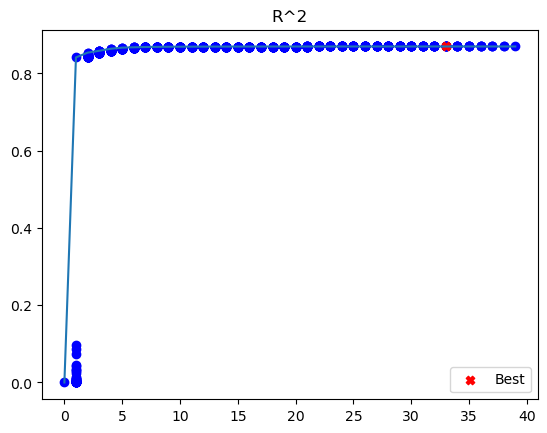

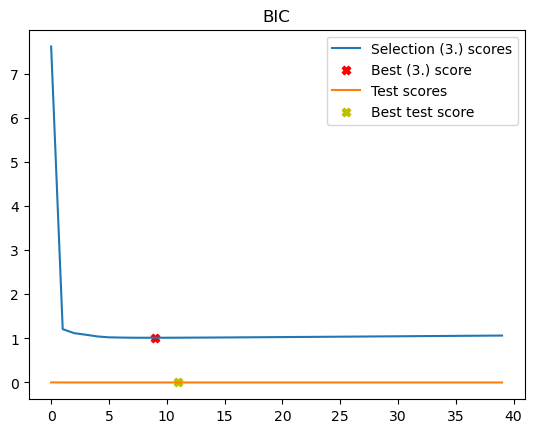

In [35]:
sigma = estimate_sigma(X_train, y_train)

forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="BIC",
                  verbose=True)

The best result for test is the subset is:

`Best configuration has 9 features
Features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June']
Total number of trained models: 780`

A lot of features are not relevant to predict ExitRates... I will see if the categorical variables are also not relevant to predict Revenue. This is in contrast with the result saw with the F-test: since the higher value we expected to see a model with more variable. But I also need to keep in mind that the result are not precise since we were considering one-hot encoded variables.

### Forward Feature Selection with CV

Now we can perform the same method with cross validation to see if I obtain a better result. 

............
Best model (M0) with 1 features: ['BounceRates']
M0 subset score (3.): 0.8399691408563431
............
Best model (M1) with 2 features: ['BounceRates', 'Administrative']
M1 subset score (3.): 0.8522514554087941
............
Best model (M2) with 3 features: ['BounceRates', 'Administrative', 'ProductRelated']
M2 subset score (3.): 0.8570476747510882
............
Best model (M3) with 4 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor']
M3 subset score (3.): 0.8623941454073251
............
Best model (M4) with 5 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues']
M4 subset score (3.): 0.8652463418895746
............
Best model (M5) with 6 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2']
M5 subset score (3.): 0.8661608015852073
............
Best model (M6) with 7 features: ['BounceRates', 'Administrative', 'ProductR

............
Best model (M28) with 29 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June', 'OperatingSystems_3', 'Weekend', 'Region_3', 'Month_May', 'Region_9', 'Month_Aug', 'Month_Mar', 'Month_Oct', 'VisitorType_Other', 'Region_1', 'ProductRelated_Duration', 'Administrative_Duration', 'Informational_Duration', 'Region_6', 'Month_Jul', 'Month_Feb', 'Month_Dec', 'OperatingSystems_1', 'Region_5', 'Region_7']
M28 subset score (3.): 0.8669489766816751
............
Best model (M29) with 30 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June', 'OperatingSystems_3', 'Weekend', 'Region_3', 'Month_May', 'Region_9', 'Month_Aug', 'Month_Mar', 'Month_Oct', 'VisitorType_Other', 'Region_1', 'ProductRelated_Duration', 'Administrative_Duration', 'Informational_Duration', 'Region_6', '

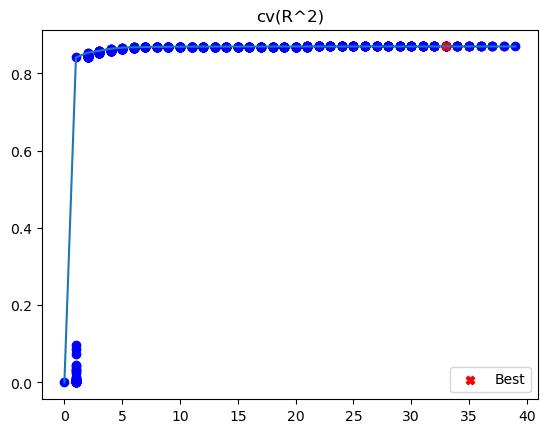

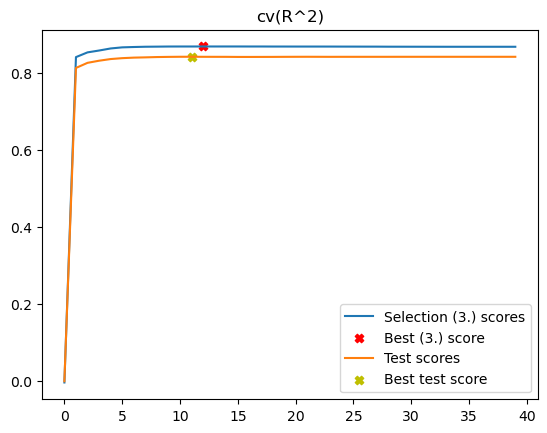

In [36]:
from sklearn.model_selection import cross_val_score

def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=mpg_test_seed)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator


cv = 10
sigma = estimate_sigma(X_train, y_train)
forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score), cv=cv), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

The result is not changed: 
`Best configuration has 12 features
Features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June', 'OperatingSystems_3', 'Weekend', 'Region_3']
Total number of trained models: 1170`

With cross validation we obtain a model that have more features. We can observe some interesting things
- BounceRates is the first variable and this is quite obvious since it is the percentage of visitors who enter the website and leave without viewing any other pages during that session. The user search for something and didn't look to other competitors or other products. 
- A lot of categorical variable are quite useless. 

The final score of this model is 0.8675366320875992

### Linear regression on subset
Now let's check the new metrics for the linear regression model on the subset that we just obtained:

In [37]:
selected = ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 
            'PageValues', 'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June', 
            'OperatingSystems_3', 'Weekend', 'Region_3']
X_selected = X[selected]
seed_v2=40
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y,
                                                                test_size=y_test.shape[0], 
                                                                random_state=seed_v2)

model = LinearRegression()                       
model = model.fit(X_train_selected, y_train_selected)        
y_predict_test = model.predict(X_test_selected)     
y_predict_train = model.predict(X_train_selected)


print("Train R2 score ", r2_score(y_train_selected, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train_selected, y_predict_train))

print("Test R2 score ", r2_score(y_test_selected, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test_selected, y_predict_test))

Train R2 score  0.8694281516937945
Train MSE score  0.0003064743972846893
Test R2 score  0.8407707646356074
Test MSE score  0.00035899236006029596


The $R^2 has not changed. Anyway using less variables means having low variance and the model itself is less complex 

## Ridge
Since we are dealing with a lot of features with some correlation between them, we can try to apply Ridge regression. 
Ridge regression is a form of linear regression in which an additional smoothing term, known as the "L2 penalty", is introduced to control the complexity of the model. This smoothing term is a further penalty added to the standard linear regression cost function.
We usually apply Ridge when it comes to overfitting, it's not our case. However, we are dealing with many features and we can try to see if we can get better results.

In [38]:
from sklearn.linear_model import RidgeCV

modelRidge = RidgeCV(alphas=[0.001,0.01,1,10])
modelRidge.fit(X_train,y_train)

y_predict_test = modelRidge.predict(X_test)      
y_predict_train = modelRidge.predict(X_train)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

Train R2 score  0.8697460534509328
Test R2 score  0.840792673835058
Train MSE score  0.0003057282276418562
Train MSE score  0.0003057282276418562


Same results, we don't see any improvement

## Lasso
Now let's try to apply Lasso as model. This is a regularized linear regression technique that uses L1 regularization. It is used to address various problems and has several features that make it useful in different situations, such as variable selection in model that have many predicotrs. It also handle multicollinearity: if independent variables are highly correlated (multicollinearity), Lasso tends to prefer one of the correlated variables and exclude others, while Ridge Regression (L2 regularization) tends to shrink all variables without eliminating them completely.

In [39]:
# apply lasso regression on the train set with regularization parameter alpha = 1
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Lasso

modelLasso= Lasso(alpha=0.0001) #we can try with different values
modelLasso.fit(X_train, y_train)

y_predict_test = modelLasso.predict(X_test)      
y_predict_train = modelLasso.predict(X_train)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

Train R2 score  0.8671433197048796
Test R2 score  0.8394798993964157
Train MSE score  0.0003118372876456907
Train MSE score  0.0003118372876456907


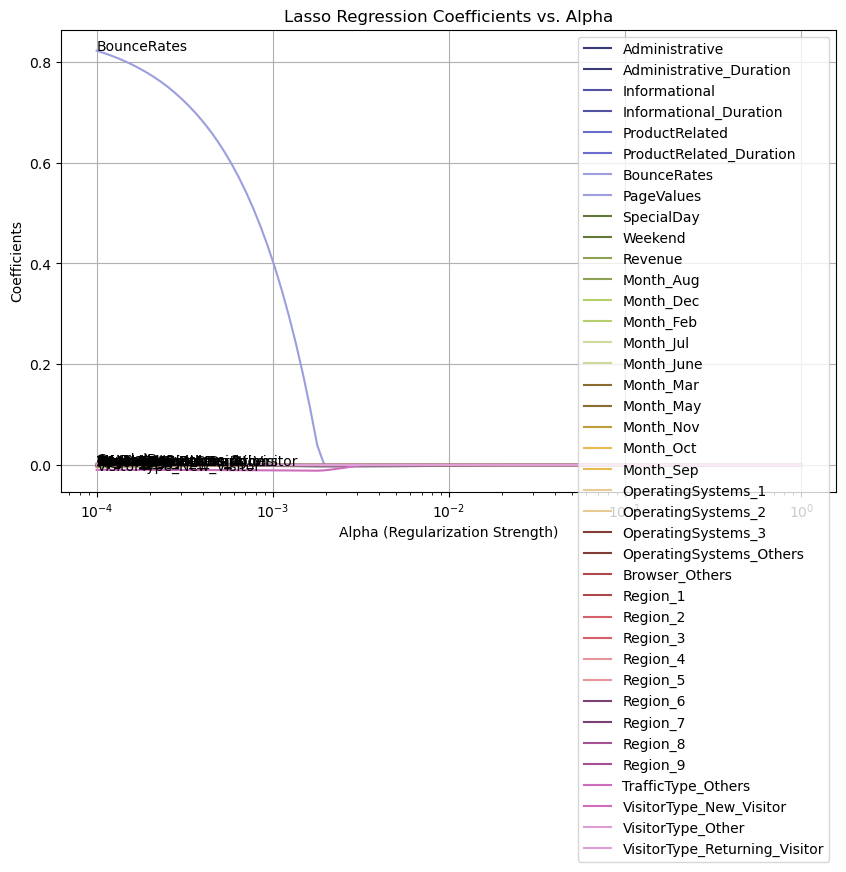

In [40]:
#Try different alphas
alphas = np.logspace(-4, 0, 100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
coefs = np.array(coefs)
# Define the colors for the lines
colors = plt.cm.tab20b(np.linspace(0, 1, coefs.shape[1]))

# Draw the graph with custom colors for each line
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], color=colors[i])
    # Add a label to each line indicating the feature it represents
    plt.text(alphas[0], coefs[0, i], X.columns[i], fontsize=10, color='Black')

plt.xscale('log')  # Logarithmic scale on the x-axis to better visualize alpha values
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficients')
plt.title('Lasso Regression Coefficients vs. Alpha')
plt.legend(X.columns, loc='upper right')
plt.grid(True)
plt.show()

BounceRates is the most significative variables. 
Anyway, to obtain better result we are forced to impose alpha=0.001. In this case, Lasso behaves similarly to linear regression without any regularization. 

## Recovering missing values 
At the end of this analysis we have found Linear Regression as the best model and we have selected the best 12 features to predict ExitRates. The next step is to replace the NaN values in both train and test dataset.

In [41]:
X = noNan.drop('ExitRates', axis=1)
y = noNan['ExitRates']

relevant= ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType_New_Visitor', 'PageValues', 
           'OperatingSystems_2', 'Revenue', 'SpecialDay', 'Month_June', 'OperatingSystems_3', 'Weekend', 
           'VisitorType_Other', 'Month_Jul', 'ProductRelated_Duration', 'Region_1', 'Month_Dec', 'Month_Nov', 
           'Region_3']
X_relevant = X[relevant]

model = LinearRegression(fit_intercept=True)   
model = model.fit(X_relevant, y)          
y_predict_train = model.predict(X_relevant)  

missing_indices = train_data[train_data['ExitRates'].isnull()].index

# Same Length
y_predict_train = y_predict_train[:len(missing_indices)]

# Imputing values
train_data.loc[missing_indices, 'ExitRates'] = y_predict_train

In [42]:
#Loading the test dataset to impute the values
test_data = pd.read_csv("data/test_set_online_shoppers_intention.csv")

#Engoding for Test data
merge_rare_categories(test_data,"Browser",100)
merge_rare_categories(test_data,"OperatingSystems",20)
merge_rare_categories(test_data,"TrafficType",100)

categorical_columns = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType']
test_enc = pd.get_dummies(test_data[categorical_columns].astype(str))
test_data.head()

test_data = test_data.drop(categorical_columns, axis=1) 
test_data = pd.concat([test_data, test_enc], axis=1)

test_data['Revenue'] = test_data['Revenue'].astype(int)
test_data['Weekend'] = test_data['Weekend'].astype(int)
test_data.head()


#Imputing values 
missing_indices = test_data[test_data['ExitRates'].isnull()].index

# Same length?
y_predict_test = y_predict_test[:len(missing_indices)]

# Inserting predicted values of "y_predict_test" into "train_data"
test_data.loc[missing_indices, 'ExitRates'] = y_predict_test

test_data.drop("Unnamed: 0", axis=1, inplace=True)

<a id='section_3'></a>
# Classification model
Now we wnat to build a classification model to predict if an online shopper is likely to perform a purchase. 

We will perform these analysis:

- Features selection
- Compare different algorithms
- Identify the one that works the best on this dataset
- Test the performance of the best algorithm on the provided test set.

We have already perform one-hot encoding, so we can go straight to the classification models.

To predict the `Revenue` variable we will use (and compare):
- Logistic Regression
    - Feature selection
    - ExitRate vs the remaining variables
- Lasso
- Linear Discriminant Analysis
- LDA + RandomForest
- LDA polynomial
- QDA
- KNN
- Support Vector Machines

Since our dataset is heavily imbalanced (75% vs 15%), using accuracy as the evaluation metric might be misleading. The reason is that even a very simple model that always predicts customers have made a purchase would achieve an accuracy of 75%, as most instances belong to that class. In the appendix this problem is solved using 

We can also use F1-score that is a metric that combines precision and sensitivity into a single measure. It is particularly useful when classes are imbalanced. A high F1-score indicates a good balance between precision and sensitivity.
For each model you will find the classification_report which print for each class (Revenue=0 and Revenue=1) the different valule fo the metrics for test, in pariticular:
- Precision -> Ability of the model to correctly identify positive instances (True Positives) out of all instances predicted as positive. TP / (TP + FP)
- Recall (also called Sensitivity or True Positive Rate) -> ability of the model to correctly identify all positive instances out of all instances that truly belong to the positive class (True Positives + False Negatives). TP / (TP + FN).
- F1-score -> harmonic mean of precision and recall. It is a balanced metric that considers both precision and recall. 2 * (precision * recall) / (precision + recall).
- Support: Support is the number of actual occurrences of each class in the test dataset.

**The classification_report calculates the metrics more comprehensively, providing precision, recall, and F1-score for both classes (class 0 and class 1) along with other statistics like support and accuracy. The classification_report also uses a different method to compute these metrics, which takes into account both classes and combines them based on a weighted average to provide overall measures. So the results between manual metrics and classification report are different**


## Logistic Regression
Logistic regression is a binary classification algorithm to predict the probability that a sample belongs to a particular class. 

In this case the dependent variable is `Revenue` which indicates whether or not a customer has purchased from the eshop. Our aim is to model the relationship between the features and `Revenue`.

In [43]:
#Define X train and Y train
X_train = train_data.drop('Revenue', axis=1)
y_train = train_data['Revenue']

#Define X test and y_test
X_test = test_data.drop('Revenue', axis=1)
y_test = test_data['Revenue']
y_train = y_train.to_numpy().ravel() # As suggested from warning
y_test= y_test.to_numpy().ravel() 

In [44]:
column_names = X_train.columns.tolist()

In [45]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

def recall(y_pred, y_true):
    true_positive = ((y_pred == 1) & (y_true == 1)).sum()
    false_negative = ((y_pred == 0) & (y_true == 1)).sum()
    recall_score = true_positive / (true_positive + false_negative)
    return recall_score

def f1_score(y_pred, y_true):
    true_positive = ((y_pred == 1) & (y_true == 1)).sum()
    false_positive = ((y_pred == 1) & (y_true == 0)).sum()
    false_negative = ((y_pred == 0) & (y_true == 1)).sum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer, jaccard_score

#Adding max iters for warning
modelLR = LogisticRegression(solver="lbfgs", penalty=None, max_iter =10000)
modelLR.fit(X_train, y_train)
y_predict = modelLR.predict(X_train)   

print("Train recall:", recall(y_train, modelLR.predict(X_train)))
print("Test recall:", recall(y_test, modelLR.predict(X_test)))
print("Train F1:", f1_score(y_train, modelLR.predict(X_train)))
print("Test F1:", f1_score(y_test, modelLR.predict(X_test)))
print(classification_report(y_test, modelLR.predict(X_test), ))

Train recall: 0.7387140902872777
Test recall: 0.7470817120622568
Train F1: 0.49723756906077343
Test F1: 0.5303867403314917
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2615
           1       0.75      0.41      0.53       467

    accuracy                           0.89      3082
   macro avg       0.82      0.69      0.73      3082
weighted avg       0.88      0.89      0.88      3082



The logistic regression model is performing well in terms of precision for class 0. However, it is not performing as well for class 1, as evidenced by the lower recall and F1-score. This indicates that the model is not capturing all the positive samples (class 1) effectively. The recall is relatively low, indicating that the model is not effectively identifying all the actual positive cases, missing around 58% of them.

### Linear regression with ExitRates

In [47]:
X_train_exit = train_data[['ExitRates']]
X_test_exit = test_data[['ExitRates']]

# Model
modelLR2 = LogisticRegression(solver="lbfgs", penalty=None, max_iter =10000)

# Train
modelLR2.fit(X_train_exit, y_train)

# Print metrics
print("Accuracy on train:", accuracy(y_train, modelLR2.predict(X_train_exit)))
print("Accuracy on test:", accuracy(y_test, modelLR2.predict(X_test_exit)))
print(classification_report(y_test, modelLR2.predict(X_test_exit), zero_division=1))

Accuracy on train: 0.8441825259515571
Accuracy on test: 0.8484750162232316
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2615
           1       1.00      0.00      0.00       467

    accuracy                           0.85      3082
   macro avg       0.92      0.50      0.46      3082
weighted avg       0.87      0.85      0.78      3082



ExitRates seems to be useless for predicting class 1. However it also shows a worse accuracy value. 
We can conclude by saying that there is no reason to use a model with only the variable in question, but rather it would be completely wrong.

### Lasso

Now we do something similar to the procedure seen in the Regression part

Text(0, 0.5, 'beta')

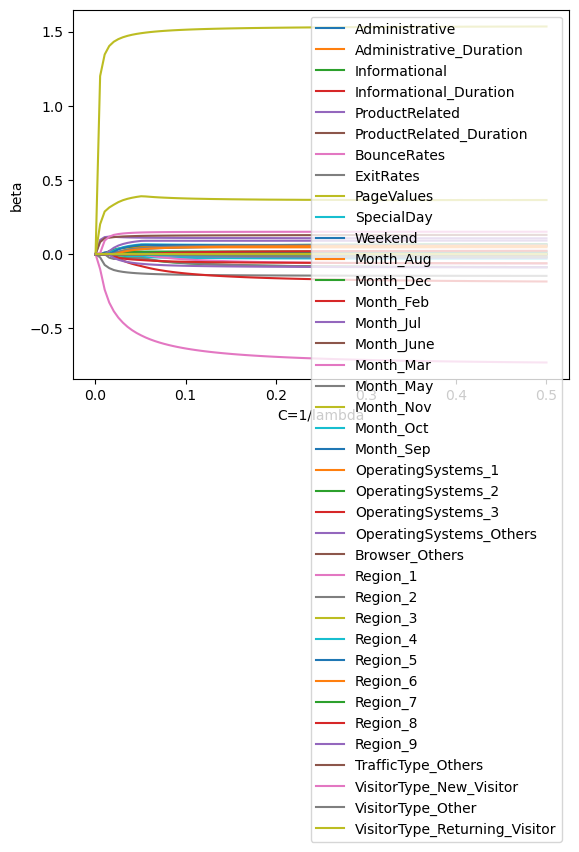

In [48]:
C_vals = np.linspace(1e-4, 0.5, 100)
betas = []

from sklearn import preprocessing
X_std = preprocessing.scale(X_train)

for C in C_vals:
    model = LogisticRegression(solver='saga', penalty='l1', C=C, max_iter =1000 )
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    #beta = (beta - beta.min()) / beta.ptp()
    betas.append(beta)
betas = np.stack(betas, axis=1)  # [Nfeat, NCvals]

for beta, name in zip(betas, X_train):
    plt.plot(C_vals, beta, label=name)
plt.legend()
plt.xlabel("C=1/lambda")
plt.ylabel("beta")

In [49]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 0.5, 1]}

# Cross validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Best parameters using train data
grid_search.fit(X_train, y_train)

# Find best C
best_C = grid_search.best_params_['C']

# Addestra il modello sulla totalità del dataset di addestramento utilizzando il miglior C
best_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=20000)
best_model.fit(X_train, y_train)

print(best_C)

print("Train recall:", recall(y_train, best_model.predict(X_train)))
print("Test recall:", recall(y_test, best_model.predict(X_test)))
print("Train F1:", f1_score(y_train, best_model.predict(X_train)))
print("Test F1:", f1_score(y_test, best_model.predict(X_test)))
print(classification_report(y_test, best_model.predict(X_test)))

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.

0.01
Train recall: 0.7370689655172413
Test recall: 0.7717842323651453
Train F1: 0.48011230697239116
Test F1: 0.5254237288135594
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2615
           1       0.77      0.40      0.53       467

    accuracy                           0.89      3082
   macro avg       0.84      0.69      0.73      3082
weighted avg       0.88      0.89      0.88      3082



/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


This model has a slightly higher recall value for the positive class (0.40 compared to 0.42) and a slightly higher F1-score (0.53 compared to 0.54) than the Logistic Regression. This indicates that Lasso is slightly better at correctly identifying instances of the positive class.
The overall results are not satisfactory yet.

## Linear Discriminant Analysis
The main objective of LDA is to find a linear combination of the input features that maximizes the separation between the classes while minimizing the variance within each class. In other words, LDA aims to project the data onto a lower-dimensional space in such a way that the class separation is maximized.

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
modelLDA = LDA()
modelLDA = modelLDA.fit(X_train, y_train)

print("Train recall:", recall(y_train, modelLDA.predict(X_train)))
print("Test recall:", recall(y_test, modelLDA.predict(X_test)))
print("Train F1:", f1_score(y_train, modelLDA.predict(X_train)))
print("Test F1:", f1_score(y_test, modelLDA.predict(X_test)))
print(classification_report(y_test, modelLDA.predict(X_test)))

Train recall: 0.7403993855606759
Test recall: 0.7706422018348624
Train F1: 0.4608030592734225
Test F1: 0.49051094890510943
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2615
           1       0.77      0.36      0.49       467

    accuracy                           0.89      3082
   macro avg       0.83      0.67      0.71      3082
weighted avg       0.88      0.89      0.87      3082



The results are pretty much the same as previous models. However, we can try another approach thanks to LDA.

### LDA + Random Forest (Out of curiosity)
The combination of LDA with Random Forest involves the following steps:
1. LDA is applied to the original high-dimensional data to project it into a lower-dimensional space with the desired number of components (k). This transformation results in a new set of features that are more discriminative for the classification task
2. The transformed data is used to train the Random Forest classifier. The Random Forest model learns the relationships between the transformed features and the class labels, taking advantage of the reduced dimensionality and improved class separability achieved by LDA.

The approach of combining LDA with Random Forest can be beneficial when you have a high-dimensional dataset and want to improve the classification performance by reducing the feature space's dimensionality. in addition, Random Forest is known for its robustness and ability to handle complex data and potentially handle class imbalances to some extent.

In [51]:
from sklearn.ensemble import RandomForestClassifier
# Start with LDA
modelLDA = LDA()
X_train_lda = modelLDA.fit_transform(X_train, y_train)
#Then random forest
rf_classifier = RandomForestClassifier(random_state=42, max_depth=2) #defaul n_estimator=100
rf_classifier.fit(X_train_lda, y_train)

#LDA for train data
X_train_lda = modelLDA.transform(X_train)
# LDA for test data
X_test_lda = modelLDA.transform(X_test)
# Predict on train
y_train_predRF = rf_classifier.predict(X_train_lda)
# Predict on test
y_test_predRF = rf_classifier.predict(X_test_lda)

print("Train recall:", recall(y_train, y_train_predRF))
print("Test recall:", recall(y_test,y_test_predRF))
print("Train F1:", f1_score(y_train, y_train_predRF))
print("Test F1:", f1_score(y_test, y_test_predRF))
print(classification_report(y_test, y_test_predRF))

Train recall: 0.6847720659553831
Test recall: 0.7131147540983607
Train F1: 0.5711974110032363
Test F1: 0.6266506602641057
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2615
           1       0.71      0.56      0.63       467

    accuracy                           0.90      3082
   macro avg       0.82      0.76      0.78      3082
weighted avg       0.89      0.90      0.89      3082



The recall for the positive class (pruchasing) is 56%, which means the model is capturing a significant portion of the actual positive cases. This is an improvement over the simple LDA, where the recall for the positive class was only 36%. 
This model shows promising results in terms of accuracy, precision, recall, and F1-score. It seems to have a good ability to correctly identify both negative and positive class instances.
Let's try with a different approach.

## LDA with polynomial
We make a pipeline to apply the polynomial tranformation on the features and then fit a LDA model over these transformed (and "new") features. 
The decision boundary remains liner. 

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

modelLDAp = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lda', LDA())])
modelLDAp = modelLDAp.fit(X_train, y_train)

print("Train recall:", recall(y_train, modelLDAp.predict(X_train)))
print("Test recall:", recall(y_test, modelLDAp.predict(X_test)))
print("Train F1:", f1_score(y_train, modelLDAp.predict(X_train)))
print("Test F1:", f1_score(y_test, modelLDAp.predict(X_test)))
print(classification_report(y_test, modelLDAp.predict(X_test)))

Train recall: 0.7474226804123711
Test recall: 0.6945244956772334
Train F1: 0.6014102032351721
Test F1: 0.5921375921375922
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2615
           1       0.69      0.52      0.59       467

    accuracy                           0.89      3082
   macro avg       0.81      0.74      0.77      3082
weighted avg       0.88      0.89      0.89      3082



The weighted average F1-score is 84%, which considers the class support (the number of samples in each class) when calculating the average. This means that the model's overall performance is decent, but it is impacted by the imbalance between the classes. So I am facing the same problem as before

### Best degree
Now we can use Cross Validation and Grid Search to find the best degree for the Polynomial. We set a range between 1 and 3 because of the computational time. In this case we will define a new scorer to get the best recall for calss 1 (no purchase).

In [53]:
from sklearn.model_selection import GridSearchCV

def recall_class_1(y_true, y_pred):
    from sklearn.metrics import recall_score
    return recall_score(y_true, y_pred, pos_label=1)

modelBest = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA())])
params = {'poly__degree': range(1, 3)}
cv = GridSearchCV(modelBest, params, refit=True, cv=10, 
                  scoring=make_scorer(recall_class_1), n_jobs=-1 )
cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1, param_grid={'poly__degree': range(1, 3)},
             scoring=make_scorer(recall_class_1))

In [54]:
cv.best_params_
cv.best_score_
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.065258,0.028357,0.001968,0.000276,1,{'poly__degree': 1},0.305556,0.340278,0.340278,0.305556,0.368056,0.388889,0.291667,0.282759,0.354167,0.340278,0.331748,0.032684,2
1,9.069942,3.040045,0.030811,0.020667,2,{'poly__degree': 2},0.430556,0.513889,0.486111,0.451389,0.527778,0.486111,0.444444,0.413793,0.486111,0.465278,0.470546,0.034318,1


  (best param_poly__degree: 2) CV accuracy: 0.4705459770114942
  (best param_poly__degree: 2) Test accuracy: 0.8922777417261518
Test recall: 0.6945244956772334
Test F1: 0.5921375921375922
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2615
           1       0.69      0.52      0.59       467

    accuracy                           0.89      3082
   macro avg       0.81      0.74      0.77      3082
weighted avg       0.88      0.89      0.89      3082



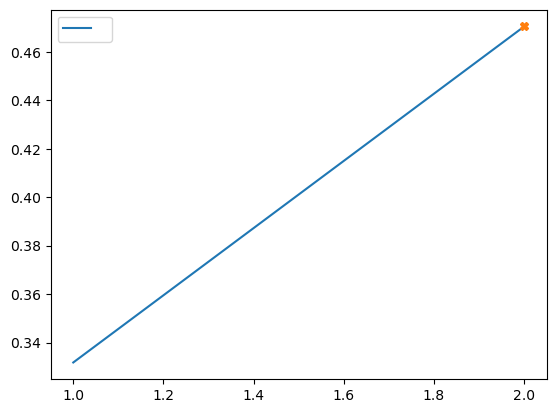

In [55]:
#Change show_result to take into account my metrics
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    
    # Plot the CV (mean) scores for all possible parameters
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    # Find the best
    best_idx = np.argmax(results['mean_test_score'])
    best_degree = results[params][best_idx]
    best_score = results['mean_test_score'][best_idx]

    # Plot it as a cross
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx],marker='X')
    plt.legend()

    print(prefix, f"(best {params}: {best_degree}) CV accuracy:", best_score)
    print(prefix, f"(best {params}: {best_degree}) Test accuracy:", accuracy(y_test, cv.best_estimator_.predict(X_test)))
    print("Test recall:", recall(y_test, cv.best_estimator_.predict(X_test)))
    print("Test F1:", f1_score(y_test, cv.best_estimator_.predict(X_test)))
    print(classification_report(y_test, cv.best_estimator_.predict(X_test)))
show_results(cv, X_test, 'param_poly__degree')

We have a diagonal line because we have just two grades, you can try to compute for a bigger range but the computation takes a lot of time. 
The new model has higher precision, recall, and F1-score for both classes compared to the one without polynomial. This means that the this model performs better in correctly predicting instances for both class 0 and class 1.
Overall the polynomial LDA demonstrates better performance in correctly classifying instances for both classes, making it a more favorable model for this classification task.

## QDA
In QDA, like LDA, the main assumption is that the input features follow a Gaussian (normal) distribution, but unlike LDA, QDA relaxes the assumption that the covariance matrix of the features is the same for all classes. This means that QDA allows each class to have its own covariance matrix, which can better capture complex relationships between features within each class.

In [56]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

modelQDA = QDA()
modelQDA = modelQDA.fit(X_train, y_train)

print("Train recall:", recall(y_train, modelQDA.predict(X_train)))
print("Test recall:", recall(y_test, modelQDA.predict(X_test)))
print("Train F1:", f1_score(y_train, modelQDA.predict(X_train)))
print("Test F1:", f1_score(y_test, modelQDA.predict(X_test)))
print(classification_report(y_test, modelQDA.predict(X_test)))

Train recall: 0.4218671992011982
Test recall: 0.4465592972181552
Train F1: 0.4907084785133565
Test F1: 0.5304347826086957
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      2615
           1       0.45      0.65      0.53       467

    accuracy                           0.82      3082
   macro avg       0.69      0.75      0.71      3082
weighted avg       0.86      0.82      0.84      3082



/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Again the model seems to struggle with the minority class (class 1) due to class imbalance. But I obtained better result with respect to Logistic Regression and LDA

## KNN
The K-Nearest Neighbors (KNN) classifier is a simple and popular supervised machine learning algorithm used for classification tasks.
When a new data point is given, the algorithm looks at its "K" nearest neighbors in the training dataset (based on some distance metric, typically Euclidean distance), and assigns the class label that is most common among those neighbors. The majority class label determines the classification of the new data point.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

print("Train recall:", recall(y_train, knn.predict(X_train)))
print("Test recall:", recall(y_test, knn.predict(X_test)))
print("Train F1:", f1_score(y_train, knn.predict(X_train)))
print("Test F1:", f1_score(y_test, knn.predict(X_test)))
print(classification_report(y_test, knn.predict(X_test)))

Train recall: 0.8268733850129198
Test recall: 0.8045112781954887
Train F1: 0.350109409190372
Test F1: 0.3566666666666667
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2615
           1       0.80      0.23      0.36       467

    accuracy                           0.87      3082
   macro avg       0.84      0.61      0.64      3082
weighted avg       0.87      0.87      0.84      3082



The KNN model has relatively low recall for class 1 indicates that the model has difficulty identifying positive instances. The F1-score, which considers both precision and recall, provides a balanced measure of the model's performance. The F1-score for class 1 is relatively low (0.36), indicating that the model struggles to achieve a good trade-off between precision and recall for the positive class.
We chose k=10 at random, let's see what is the best number of k to be considered.

### Deciding K
Again we use the function recall_class_1 to have a better result for recall for class1 (no purchase)

In [58]:
from sklearn.model_selection import GridSearchCV
model = KNeighborsClassifier()
params = {'n_neighbors': range(2, 30)}
folds=10

cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(recall_class_1))
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 30)},
             scoring=make_scorer(recall_class_1))

  (best param_n_neighbors: 3) CV accuracy: 0.3483860153256705
  (best param_n_neighbors: 3) Test accuracy: 0.863075924724205
Test recall: 0.5742574257425742
Test F1: 0.4519480519480519
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2615
           1       0.57      0.37      0.45       467

    accuracy                           0.86      3082
   macro avg       0.73      0.66      0.69      3082
weighted avg       0.85      0.86      0.85      3082



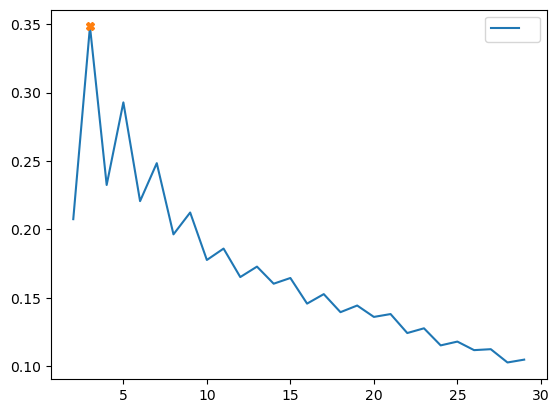

In [59]:
show_results(cv, X_test, "param_n_neighbors")

Compared to the previous model, reducing the value of k seems to have improved the recall for class 1 (positive class). The recall value has increased from 0.23 to 0.37, indicating that the model is now better at identifying some of the positive instances, reducing the number of false negatives.


### Feature normalization
Now we want to try if the feature normalization can improve the previous results obtained with KNN. TO do this we defin a function that find the best recall for class 1 (no purchasing)

 Unnormalized (best param_n_neighbors: 3) CV accuracy: 0.3483860153256705
 Unnormalized (best param_n_neighbors: 3) Test accuracy: 0.863075924724205
Test recall: 0.5742574257425742
Test F1: 0.4519480519480519
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2615
           1       0.57      0.37      0.45       467

    accuracy                           0.86      3082
   macro avg       0.73      0.66      0.69      3082
weighted avg       0.85      0.86      0.85      3082

Unnormalized:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2615
           1       0.57      0.37      0.45       467

    accuracy                           0.86      3082
   macro avg       0.73      0.66      0.69      3082
weighted avg       0.85      0.86      0.85      3082

 StandardScaler (best param_knn__n_neighbors: 15) CV accuracy: 0.861916461916462
 StandardScaler (best param_knn__n_neighbo

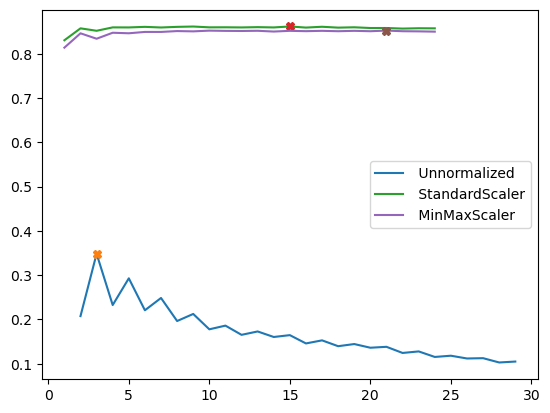

In [60]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)
params = {'knn__n_neighbors': range(1, 25)}
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
cv_std = GridSearchCV(model_std, params, refit=True, cv=10, scoring=make_scorer(accuracy))
cv_std.fit(X_train, y_train)

model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
cv_minmax = GridSearchCV(model_minmax, params, refit=True, cv=10, scoring=make_scorer(accuracy), n_jobs=-1)
cv_minmax.fit(X_train, y_train)

# Print the classification report for each model
show_results(cv, X_test, "param_n_neighbors", prefix="Unnormalized")
print("Unnormalized:")
print(classification_report(y_test, cv.predict(X_test)))

show_results(cv_std, X_test, 'param_knn__n_neighbors', "StandardScaler")
print("StandardScaler:")
print(classification_report(y_test, cv_std.predict(X_test)))

show_results(cv_minmax, X_test, 'param_knn__n_neighbors', "MinMaxScaler")
print("MinMaxScaler:")
print(classification_report(y_test, cv_minmax.predict(X_test)))

None of the models have a good performance in correctly identifying positive class instances (class 1).
The model without normalization has higher recall and F1-score for class 1. 
Again class imbalance might be affecting the models' ability to learn patterns from the positive class. 

## Best model

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


lr CV F1-score classe 1: 0.4955,  test F1-score classe 1: 0.5387
ls CV F1-score classe 1: 0.5345,  test F1-score classe 1: 0.5772
lda CV F1-score classe 1: 0.4572,  test F1-score classe 1: 0.4905
lda_rf CV F1-score classe 1: 0.5575,  test F1-score classe 1: 0.6267
lda_poly CV F1-score classe 1: 0.5597,  test F1-score classe 1: 0.5921


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

qda CV F1-score classe 1: 0.4744,  test F1-score classe 1: 0.5304
knn CV F1-score classe 1: 0.4270,  test F1-score classe 1: 0.4519
knn_std CV F1-score classe 1: 0.3787,  test F1-score classe 1: 0.4379
knn_minmax CV F1-score classe 1: 0.2919,  test F1-score classe 1: 0.3315
Miglior modello per l'F1-score della classe 1:  lda_rf
Miglior F1-score per la classe 1: 0.6267


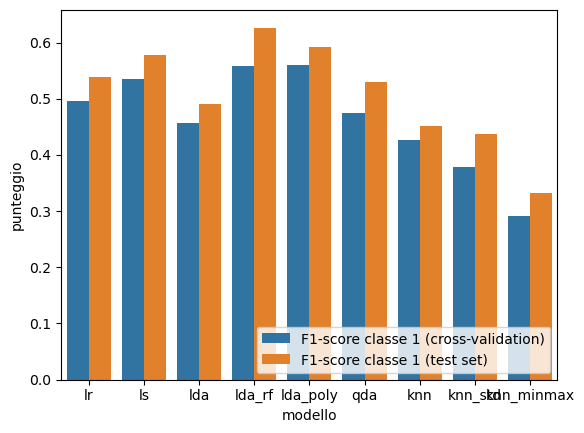

In [61]:
def f1_class1(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return report['1']['f1-score']

lr= LogisticRegression(solver="newton-cg", penalty=None, max_iter =10000)   
ls = LogisticRegression(solver='saga', penalty='l1', C=0.01, max_iter =10000)
lda = LDA()
lda_rf = Pipeline([('lda', LDA()),
                     ('rf', RandomForestClassifier(random_state=42, max_depth=2))])

lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA())])
qda = QDA()
knn = KNeighborsClassifier(n_neighbors=3)

knn_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))])

knn_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))])

from collections import OrderedDict
models = OrderedDict([('lr', lr), ('ls', ls), ('lda', lda), ('lda_rf', lda_rf), ('lda_poly', lda_poly), ('qda', qda),
                      ('knn', knn), ('knn_std', knn_std), ('knn_minmax', knn_minmax)])

cv_scores, test_scores = [], []
best_f1_class1 = 0.0
best_model_name = ''


for name, model in models.items():
    # Calcola l'F1-score per la classe 1 usando la cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring=make_scorer(f1_class1))
    cv_score = scores.mean()
    cv_scores.append(cv_score)

    model.fit(X_train, y_train)
    
    # Scorer: best f1 on class 1 
    y_pred = model.predict(X_test)
    test_score = f1_class1(y_test, y_pred)
    test_scores.append(test_score)

    # Check if it is the best
    if test_score > best_f1_class1:
        best_f1_class1 = test_score
        best_model_name = name

    print("{} CV F1-score classe 1: {:.4f},  test F1-score classe 1: {:.4f}".format(name, cv_score, test_score))

data = pd.DataFrame()
data['modello'] = list(models.keys()) * 2
data['metrica'] = ['F1-score classe 1 (cross-validation)'] * len(cv_scores) + ['F1-score classe 1 (test set)'] * len(test_scores)
data['punteggio'] = cv_scores + test_scores

sns.barplot(x='modello', y='punteggio', data=data, hue='metrica')
plt.legend(loc='lower right')

# Stampa il modello con il miglior F1-score per la classe 1
print("Miglior modello per l'F1-score della classe 1: ", best_model_name)
print("Miglior F1-score per la classe 1: {:.4f}".format(best_f1_class1))

The class imbalance made most of the classification models unsatisfactory. 
The best-performing model turned out to be LDA+RandomFOrest, precisely because RandomForest is better at handling imbalanced classes. Nevertheless, LDA_poly also achieved interesting results. 

If we look at the toal of metrics, QDA seems to be the best mode if ou main goal is to correctly identify purchase cases, due to its higher recall. However, it should be necessary to balance this choice with the trade-off between recall and precision, as a high recall may increase the number of false positives.

In conclusion, applying methodologies for managing imbalanced classes would have allowed us to obtain better results. 


# Handling with class imbalance
We have seen that our data present a strong class imbalance:
- 85% of Revenue are false
- 15% of Revenue are true
This translate in poorly performance in our previous model because the tend to be biased towards the class Revenue=False(or 0). This leads to inaccurate prediction for our class of interest (Revenue=true)

## How class weights works
Handling class imbalance using class weights is a technique that helps improve the performance of machine learning models when dealing with imbalanced datasets. In the case of binary classification, class weights are typically defined as the inverse of the class frequencies. The idea is to make the model more sensitive to the minority class, encouraging it to correctly classify the minority class even if it means making more errors on the majority class.

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Create the logistic regression model with class weights
modelLR = LogisticRegression(solver="newton-cg", penalty=None, max_iter=10000, class_weight={0: class_weights[0], 1: class_weights[1]})

# Train the model on the training set
modelLR.fit(X_train, y_train)

# Make predictions
y_train_pred = modelLR.predict(X_train)
y_test_pred = modelLR.predict(X_test)

# Calculate and print metrics
print("Train recall:", recall_score(y_train, y_train_pred))
print("Test recall:", recall_score(y_test, y_test_pred))
print("Train F1:", f1_score(y_train, y_train_pred))
print("Test F1:", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train recall: 0.7522553782095767
Test recall: 0.7944325481798715
Train F1: 0.6145124716553289
Test F1: 0.6385542168674699
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2615
           1       0.53      0.79      0.64       467

    accuracy                           0.86      3082
   macro avg       0.75      0.84      0.78      3082
weighted avg       0.90      0.86      0.87      3082



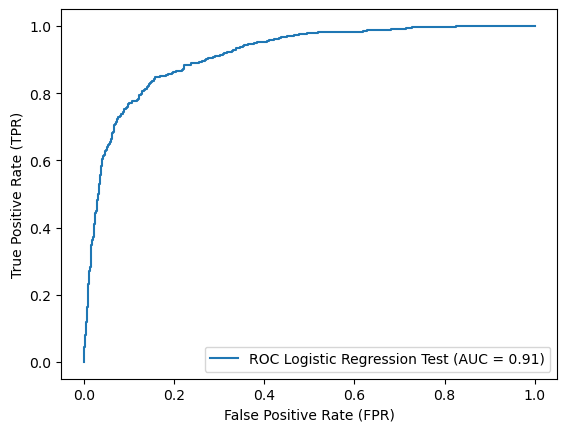

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(predict_fn, X, y, label=None):
    y_prob = predict_fn(X)[:, -1]
    fprs, tprs, thresholds = roc_curve(y, y_prob)
    roc_auc = roc_auc_score(y, y_prob)

    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC {} (AUC = {:.2f})".format(label, roc_auc))
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    
plot_roc(modelLR.predict_proba, X_test, y_test, "Logistic Regression Test")

We are getting better results with respect to the previous model. It's clear that applying a metodologi such SMOTE, Random FOrest or XGBoost 

## SVM
Support Vector Machine (SVM) is a powerful supervised machine learning algorithm used for both classification and regression tasks:
Aims to find the hyperplane with the maximum margin -> the distance between the hyperplane and the closest data points (support vectors) of the two classes. The larger the margin, the better the generalization performance of the model on unseen data.

### Hard margin
Since the dataset is too big, we take a very small subset of the data to do SVM. More sample you choose more RAM you need.


In [64]:
#Taking just a subset
seed_value = 42
np.random.seed(seed_value)

random_indices = np.random.choice(len(X), size=100, replace=False)

X_train_100 = X_train.to_numpy() #need to have the same type for X and y
X_train_100 = X_train_100[random_indices]
y_train_100 = y_train[random_indices]

In [65]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# We set a very high C value, i.e., virtually
# disabling regularization
modelSVM = SVC(kernel='linear', C=100)
modelSVM.fit(X_train_100, y_train_100)

train_acc = accuracy_score(modelSVM.predict(X_train_100), y_train_100)
test_acc = accuracy_score(modelSVM.predict(X_test), y_test)
train_recall = recall_score(y_train_100, modelSVM.predict(X_train_100))
test_recall = recall_score(y_test, modelSVM.predict(X_test))
train_f1 = f1_score(y_train_100, modelSVM.predict(X_train_100))
test_f1 = f1_score(y_test, modelSVM.predict(X_test))
classification_rep = classification_report(y_test, modelSVM.predict(X_test))

#Print all the metrics
print("SVM train recall:", train_recall)
print("SVM test recall:", test_recall)
print("SVM train F1:", train_f1)
print("SVM test F1:", test_f1)
print("SVM classification report:\n", classification_rep)

SVM train recall: 1.0
SVM test recall: 0.6252676659528907
SVM train F1: 0.9
SVM test F1: 0.5995893223819301
SVM classification report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      2615
           1       0.58      0.63      0.60       467

    accuracy                           0.87      3082
   macro avg       0.75      0.77      0.76      3082
weighted avg       0.88      0.87      0.88      3082



/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


THe trend is the same: I obtain good performance on class 0 and lower on class 1. 
The F1-score for class 0 is 0.92, indicating a good balance between precision and recall, while the F1-score for class 1 is 0.60, indicating a somewhat lower balance between precision and recall. Anyway a better model then the previous (without considering weighted linear regression)

## Logistic Regressor and Perceptron vs SVM classifier - Robustness
We know that SVM is trained to find a robust solution, that is the decision line that is most far away from the training points as possible. Let's compare this algorithm with other linear algorithms that hence also output a linear bound: **Logistic Regression** and the **Perceptron**

In [66]:
from sklearn.linear_model import LogisticRegression, Perceptron

# Train an SVM classifier
svm_model = SVC(kernel='linear', C=100) # use C=100
svm_model.fit(X_train_100, y_train_100)

# Train a Logistic Regressor
lr_model = LogisticRegression(fit_intercept=True)
lr_model.fit(X_train_100, y_train_100)

# Train a Perceptron classifier (try verbose=True and n_iter_no_change=100)
pt_model = Perceptron()
pt_model.fit(X_train_100, y_train_100)

for m in [svm_model, lr_model, pt_model]:
    train_acc = accuracy_score(y_train_100, m.predict(X_train_100))
    test_acc = accuracy_score(y_test, m.predict(X_test))
    print("{} train score: {}".format(type(m).__name__, train_acc))
    print("{} test score: {}".format(type(m).__name__, test_acc))
    print("Train recall:", recall_score(y_train,m.predict(X_train)))
    print("Test recall:", recall_score(y_test, m.predict(X_test)))
    print("Train F1:", f1_score(y_train, m.predict(X_train)))
    print("Test F1:", f1_score(y_test, m.predict(X_test)))
    print(classification_report(y_test, m.predict(X_test)))

SVC train score: 0.96
SVC test score: 0.8734587929915639
Train recall: 0.6217904233171409
Test recall: 0.6252676659528907
Train F1: 0.5979312645979312
Test F1: 0.5995893223819301
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2615
           1       0.58      0.63      0.60       467

    accuracy                           0.87      3082
   macro avg       0.75      0.77      0.76      3082
weighted avg       0.88      0.87      0.88      3082

LogisticRegression train score: 0.97
LogisticRegression test score: 0.8932511356262167
Train recall: 0.5690492713393477
Test recall: 0.6081370449678801
Train F1: 0.6002928257686676
Test F1: 0.633221850613155
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2615
           1       0.66      0.61      0.63       467

    accuracy                           0.89      3082
   macro avg       0.80      0.78      0.79      3082
weighted avg  

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted w

The logistic regression model appears to be the most balanced among the three, with good precision, recall, and F1-score for the positive class. The SVC model also performs well but with a slightly lower recall. The Perceptron, on the other hand, is not suitable for this specific problem as it struggles to identify the positive class correctly.

### Kernel Trick with SVN

In [67]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train an SVM classifier
svm_model = SVC(kernel='poly', degree=3, coef0=-5, C=5)
svm_model.fit(X_train, y_train)

print("Train recall:", recall_score(y_train,svm_model.predict(X_train)))
print("Test recall:", recall_score(y_test, svm_model.predict(X_test)))
print("Train F1:", f1_score(y_train, svm_model.predict(X_train)))
print("Test F1:", f1_score(y_test, svm_model.predict(X_test)))
print(classification_report(y_test, svm_model.predict(X_test)))

Train recall: 0.1582234559333796
Test recall: 0.1734475374732334
Train F1: 0.15816857440166493
Test F1: 0.17419354838709677
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2615
           1       0.17      0.17      0.17       467

    accuracy                           0.75      3082
   macro avg       0.51      0.51      0.51      3082
weighted avg       0.75      0.75      0.75      3082



With this model the performance is quite low with respect to the previous. Let's check the correct kernel.

### Search for the best kernel

In [68]:
from sklearn.model_selection import GridSearchCV

# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='accuracy', refit=True, n_jobs=-1) #n_jobs to speed up
svm_poly.fit(X_train_100, y_train_100)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='accuracy', refit=True, n_jobs=-1)
rbf_poly.fit(X_train_100, y_train_100)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='accuracy', refit=True, n_jobs=-1)
sigm_poly.fit(X_train_100, y_train_100)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'), n_jobs=-1,
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='accuracy')

In [69]:
for m in [svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    train_acc = accuracy_score(y_train_100, m.predict(X_train_100))
    test_acc = accuracy_score(y_test, m.predict(X_test))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_acc))
    print("test score: {}\n".format(test_acc))
    print(classification_report(y_test, m.predict(X_test)))

SVC(C=25.00075, coef0=10.0, kernel='poly')
cv score: 0.93
train score: 0.97
test score: 0.8880597014925373

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2615
           1       0.63      0.63      0.63       467

    accuracy                           0.89      3082
   macro avg       0.78      0.78      0.78      3082
weighted avg       0.89      0.89      0.89      3082

SVC(C=0.001, gamma=0.001)
cv score: 0.82
train score: 0.82
test score: 0.8484750162232316

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2615
           1       0.00      0.00      0.00       467

    accuracy                           0.85      3082
   macro avg       0.42      0.50      0.46      3082
weighted avg       0.72      0.85      0.78      3082

SVC(C=0.001, coef0=-10.0, gamma=0.001, kernel='sigmoid')
cv score: 0.82
train score: 0.82
test score: 0.8484750162232316

              precision  

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

The first model with the polynomial kernel (SVC with C=25.00075, coef0=10.0, kernel='poly') seems to be the best-performing among the three. It achieves high accuracy, reasonably balanced precision and recall for both classes, and good generalization performance. The other two models suffer from overfitting and have poor performance, especially in predicting the positive class. It's essential to select a model that can generalize well to new data and provides a balanced performance for all classes in the classification task.

## Classification metrics

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


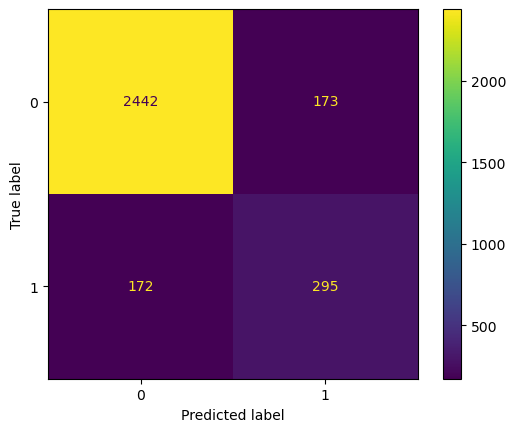

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, svm_poly.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

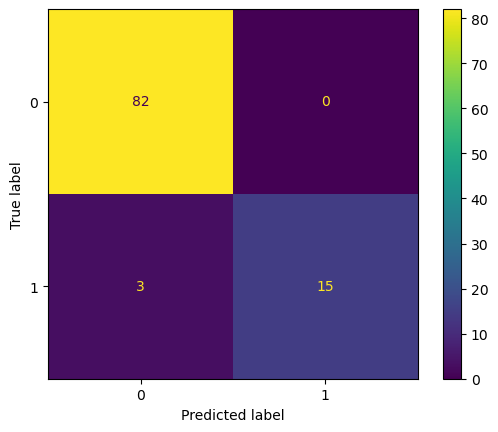

In [71]:
cm_train = confusion_matrix(y_train_100, svm_poly.predict(X_train_100))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot()
plt.show()

### ROC

In [72]:
from sklearn.metrics import roc_curve

def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()

# Selecting the best model
Now we can proceed with algorithm comparison in order to find the best model

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


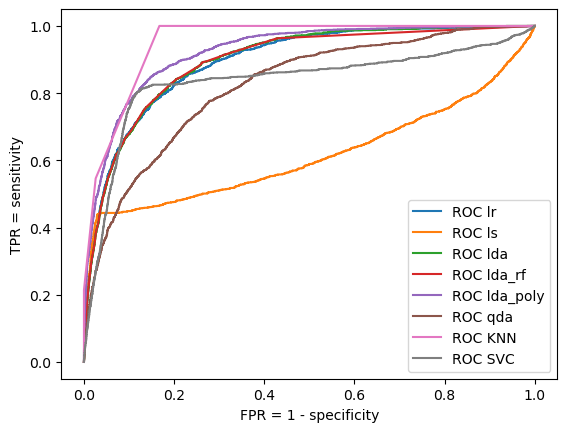

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

lr = LogisticRegression(max_iter =1000)
lr_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('lda', LogisticRegression(max_iter =1000))])

ls = LogisticRegression(solver='saga', penalty='l1', C=0.01, max_iter =10000)
lda = LDA()
lda_rf = Pipeline([('lda', LDA()),
                     ('rf', RandomForestClassifier(random_state=42, max_depth=2))])
lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA())])
qda = QDA()

svc = SVC(C=75, degree=2, kernel='poly',  probability=True)

knn = KNeighborsClassifier(n_neighbors=3)

for name, model in [('lr', lr), 
                    ('ls', ls), 
                    ('lda', lda),
                    ('lda_rf', lda_rf),
                    ('lda_poly', lda_poly), 
                    ('qda', qda),
                    ('KNN', knn),
                    ('SVC', svc)]:
    model.fit(X_train, y_train)
    plot_roc(model.predict_proba, X_train, y_train, name)

When examining the ROC curve in this background, we are primarily focused on how the model performs at low false positive rates (FPR) or how well it correctly identifies the positive class (purchases) with a low error rate. A high ROC curve (AUC) indicates the model's ability to distinguish between classes, even with imbalanced data.

Again, compared to the SVC model with the specified parameters (C=25.00075, coef0=10.0, kernel='poly'), the QDA model has a higher recall for the positive class (purchase) (0.65 vs. 0.63). This indicates that the QDA model is capable of correctly identifying a greater number of purchase cases compared to the SVC model. If  it's crucial to correctly identify a high number of purchase cases, and you're willing to tolerate some more false positives, the QDA model might be more suitable.

# Feature selection
Now that we have selected the best model we can perform feature selection over QDA to see the performance over a subset of relevant variable

In [74]:
# ===================================
#   Code from Lab03.01 - 05/05/2021
# 03.01.ScikitFeaturesSelection.ipynb
# ===================================

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            # //==========================================\\
            # || ***** Difference from previous lab ***** ||
            # \\==========================================//
            model = QDA()
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n Best configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M1) with 1 features: ['PageValues']
M1 subset score (3.): 0.8818125658125657
............
Best model (M2) with 2 features: ['PageValues', 'BounceRates']
M2 subset score (3.): 0.8862461682461682
............
Best model (M3) with 3 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor']
M3 subset score (3.): 0.8891654381654381


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M4) with 4 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3']
M4 subset score (3.): 0.8894898794898796
............
Best model (M5) with 5 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1']
M5 subset score (3.): 0.8901388791388791


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M6) with 6 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1']
M6 subset score (3.): 0.8902469872469873
............
Best model (M7) with 7 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4']
M7 subset score (3.): 0.8901389961389962


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M8) with 8 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend']
M8 subset score (3.): 0.8884073944073944


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M9) with 9 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May']
M9 subset score (3.): 0.8838640458640459


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M10) with 10 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7']
M10 subset score (3.): 0.8810525330525332


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M11) with 11 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9']
M11 subset score (3.): 0.8760799110799111


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M12) with 12 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other']
M12 subset score (3.): 0.876945243945244


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M13) with 13 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6']
M13 subset score (3.): 0.8771612261612262


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M14) with 14 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2']
M14 subset score (3.): 0.8755389025389025


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M15) with 15 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8']
M15 subset score (3.): 0.8647270387270387


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M16) with 16 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2']
M16 subset score (3.): 0.8638618228618229


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M17) with 17 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov']
M17 subset score (3.): 0.8629961389961389


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M18) with 18 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec']
M18 subset score (3.): 0.8587780507780508


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M19) with 19 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration']
M19 subset score (3.): 0.8582392652392652


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M20) with 20 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3']
M20 subset score (3.): 0.8532659412659414


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M21) with 21 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration']
M21 subset score (3.): 0.8532650052650051


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M22) with 22 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated']
M22 subset score (3.): 0.8516425646425647


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M23) with 23 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug']
M23 subset score (3.): 0.8471019071019071


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M24) with 24 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar']
M24 subset score (3.): 0.8423435123435125


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M25) with 25 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul']
M25 subset score (3.): 0.8378026208026208


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M26) with 26 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor']
M26 subset score (3.): 0.7774807534807534


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M27) with 27 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others']
M27 subset score (3.): 0.8142376272376273


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M28) with 28 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others']
M28 subset score (3.): 0.8213746343746344


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M29) with 29 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others']
M29 subset score (3.): 0.8271050661050662


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M30) with 30 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates']
M30 subset score (3.): 0.8021148941148942


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M31) with 31 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5']
M31 subset score (3.): 0.780053118053118


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M32) with 32 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational']
M32 subset score (3.): 0.75292862992863


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M33) with 33 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational', 'Month_Sep']
M33 subset score (3.): 0.650969228969229


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M34) with 34 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational', 'Month_Sep', 'Month_Oct']
M34 subset score (3.): 0.7039493389493389


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M35) with 35 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational', 'Month_Sep', 'Month_Oct', 'Month_Feb']
M35 subset score (3.): 0.6470742950742951


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M36) with 36 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational', 'Month_Sep', 'Month_Oct', 'Month_Feb', 'SpecialDay']
M36 subset score (3.): 0.6742152802152803


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M37) with 37 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational', 'Month_Sep', 'Month_Oct', 'Month_Feb', 'SpecialDay', 'Month_June']
M37 subset score (3.): 0.6844980694980695


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are col

............
Best model (M38) with 38 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational', 'Month_Sep', 'Month_Oct', 'Month_Feb', 'SpecialDay', 'Month_June', 'Informational_Duration']
M38 subset score (3.): 0.6559494559494559


/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


............
Best model (M39) with 39 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May', 'Region_7', 'Region_9', 'VisitorType_Other', 'Region_6', 'OperatingSystems_2', 'Region_8', 'Region_2', 'Month_Nov', 'Month_Dec', 'Administrative_Duration', 'Region_3', 'ProductRelated_Duration', 'ProductRelated', 'Month_Aug', 'Month_Mar', 'Month_Jul', 'VisitorType_Returning_Visitor', 'OperatingSystems_Others', 'Browser_Others', 'TrafficType_Others', 'ExitRates', 'Region_5', 'Informational', 'Month_Sep', 'Month_Oct', 'Month_Feb', 'SpecialDay', 'Month_June', 'Informational_Duration', 'Administrative']
M39 subset score (3.): 0.6403808353808355

 Best configuration has 6 features
Features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1']
Total number of trained models: 1170


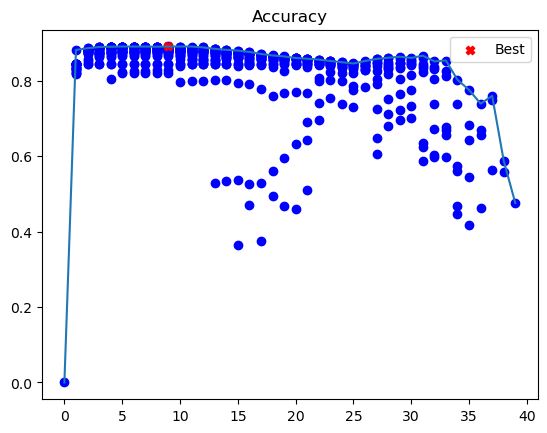

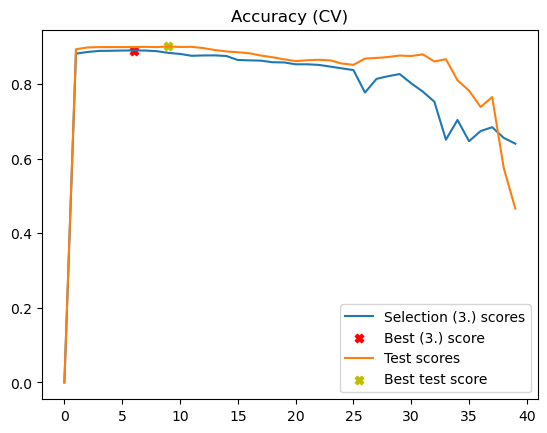

In [75]:
#Define X train and Y train again
X_train = train_data.drop('Revenue', axis=1)
y_train = train_data['Revenue']

#Define X test and y_test again
X_test = test_data.drop('Revenue', axis=1)
y_test = test_data['Revenue']
y_train = y_train.to_numpy().ravel() # As suggested from warning
y_test= y_test.to_numpy().ravel() 
cv = 10
forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv)

Here the result:
`Best model (M9) with 9 features: ['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May']`

We can notice some interesting things: 
- The majority of features are not proesent
- ExitRate is not present
- The more relevant variable are 'PageValues', 'BounceRates', 'VisitorType_New_Visitor'to predict if a costumere made a purchase or not and we have discussed it previously
- Operating System maybe represent the fact the the majority of the users choose IOS/Android or Windows/MacOS and so have larger frequencies.
- Region 1 maybe is the richer?

Now we can calculate again the metrics for QDA on this ristected model

In [76]:
resticted =['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'OperatingSystems_3', 
                                              'OperatingSystems_1', 'Region_1', 'Region_4', 'Weekend', 'Month_May']

X_train_selected = X_train[resticted]
X_test_selected = X_test[resticted]

modelQDA = QDA()
modelQDA.fit(X_train_selected, y_train)
y_predict = modelQDA.predict(X_test_selected)   

print("Train recall:", recall(y_train, modelQDA.predict(X_train_selected)))
print("Test recall:", recall(y_test, modelQDA.predict(X_test_selected)))
print("Train F1:", f1_score(y_train, modelQDA.predict(X_train_selected)))
print("Test F1:", f1_score(y_test, modelQDA.predict(X_test_selected)))
print(classification_report(y_test, modelQDA.predict(X_test_selected)))

Train recall: 0.7313915857605178
Test recall: 0.7515527950310559
Train F1: 0.5726351351351352
Test F1: 0.6134347275031686
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2615
           1       0.75      0.52      0.61       467

    accuracy                           0.90      3082
   macro avg       0.84      0.74      0.78      3082
weighted avg       0.89      0.90      0.89      3082



Again I obtain a model that is not satisfactory at all. QDA is still missing the balacing between prediction of class 0 and cluss 1. 
This demonstate that a methodology to trat class inbalance is strongly required.

Now I would like to do perform these step again with LDA + RandomForest, since this is an approach that have some attention to the imbalance.

<a id='section_4'></a>
# Clustering 
Now I will repeat again the analysis performed before using Clustering. 
>“An algorithm by which objects are grouped in classes, so that intra-class similarity is maximized and inter-class similarity is minimized”” — J. Han and M. Kamber, 2000

This approach is useful for
- Data reduction → representatives for homogeneous groups, just take into account centroids
- Natural data types → unknown properties of “natural” clusters. If data groups somehow, I might guess that there are some natural regularities
- Useful data classes → useful and suitable groupings, such are class of equivalence
- Outlier detection → unusual data objects that don’t follow the regularity

In this case I'm going to use just the train dataset. In unsupervised learning don't exist the division between train and test, so i take the larger one as the dataset for my analysis. 

In [77]:
from sklearn.preprocessing import MinMaxScaler

X = train_data.drop(['Revenue'], axis=1).to_numpy()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = train_data['Revenue'].ravel()

print(X.shape)
print(y.shape)

(9248, 39)
(9248,)


Before applying PCA, it is generally recommended to scale the data. PCA is a dimensionality reduction technique based on the data variance, so the scale of the data can significantly affect the results. In this case I chose MinMaxScaler() to preserve the value of the one-hot encoding.

## PCA 
I use PCA to chooses axes in the high-dimensional space that capture the largest amount of variation, and projects points along those axes:
- The first axis (or principal component) is chosen such that it captures the greatest variance across cells. Variance is meant as the overall variance of the cells coordinates projected on the axis.
- The next PC is chosen such as it is orthogonal (we are using eigenvalues) to the first and captures the greatest remaining amount of variation and so on
This gives a lower dimensional space where we can visualize the points

In [78]:
from sklearn.decomposition import PCA

# PCA transforms the data by reducing its dimensionality in 35 components
pca = PCA(n_components=3)

X=X.reshape(-1, 39)
X_prj=pca.fit_transform(X)
X_prj.shape

(9248, 3)

/var/folders/7x/qwmq3sh96qsdph73v_vgf3nc0000gn/T/ipykernel_8743/2624534479.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col)


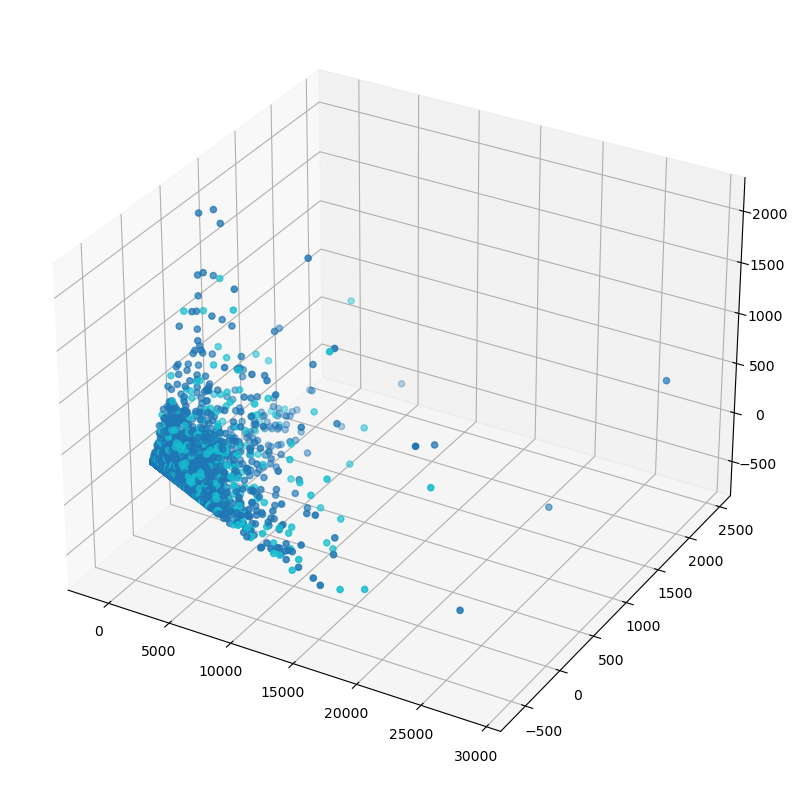

In [79]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot3d(X, labels):
    from mpl_toolkits.mplot3d import Axes3D
    pca = PCA(n_components=3)
    # We consire images as simple vectors of 64 features, reshape using the X.shape[0] information
    X = X.reshape(X.shape[0], -1)
    # Reduce features dimensionality, just for visualization
    # purpuses
    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    # Convert negative values (outliers) into positive
    labels = labels.copy()
    labels += np.abs(unique_labels.min())
    nlabels = len(unique_labels)
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    # Define color mappings
    col = ('tab10' if nlabels <= 10 else 
          ('tab20' if nlabels <= 20 else
           'hsv'))
    cmap = plt.cm.get_cmap(col)
    smap = cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)
    # Plot the 3d coordinates (similar to standard scatter plots, we just
    # need to provide an additional z coordinate!)
    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], c=labels, cmap=cmap)
    # Plot a color bar on the right
    
plot3d(X, labels=y)

By inspecting the graph we can see that the points don't aggregate in a particular way.


### TSNE
I would like  to find a low-dimensional representation of the data that preserves the distances between each point and its neighbors in the high dimensional space → Two points close in the original space must have high probability of being close in the 2D space.
t-stochastic neighbor embedding is not restricted to linear transformations, nor it is guaranteed to accurately represent distances between distant populations.
It is “stochastic” → hence, different runs might have different results. 

/var/folders/7x/qwmq3sh96qsdph73v_vgf3nc0000gn/T/ipykernel_8743/3283921015.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Accent").colors[8 - nlabels:])


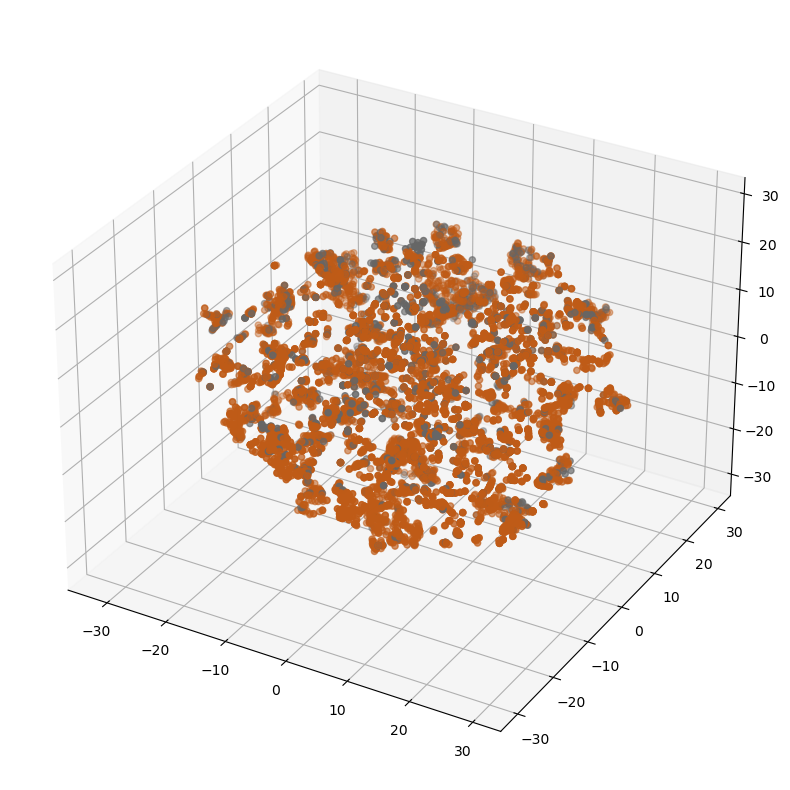

In [80]:
import matplotlib
from sklearn.manifold import TSNE
# instead of using PCA we can use simply TSNE

def plot3d_tsne(X, labels):
    #%matplotlib inline
    #%matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    
    pca = TSNE(n_components=3)
    # We consider items as simple vectors of 77 features
    X = X.reshape(-1, X.shape[1])
    # Reduce features dimensionality, just for visualization purpuses
    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    labels = labels.copy()
    nlabels = len(unique_labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define color mappings
    cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Accent").colors[8 - nlabels:])
    smap = cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)
    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[: ,2], c=labels, cmap=cmap)
     
plot3d_tsne(X_scaled, labels=y)

Data are quite mixed up.

## Hierarchical Clustering
The aim is division of samples in a hierarchy of clusters → you don’t have to state in advance the number of cluster, from 1 to as many number as the points. You can decide how many cluster you need
- Bottom up or agglomerative → from many to 1
- Top-down → from 1 to many

In this case we are analyzing two classes, but dendrograms can be useful to identify similarity relationships among data points and visualizing how clusters group together at different levels of aggregation.

I'm starting the analysis plotting the Linkage Matrix, that is the table that keeps track of the distances between clusters during the process of merging clusters to create the clustering tree, also known as a dendrogram.
The linkage matrix has dimensions of $(n-1) x 4$, where "n" is the number of initial objects. Each row of the matrix represents a fusion of two clusters, with the first two elements of the row indicating the indices of the clusters involved in the fusion, the third element indicating the distance or similarity between the merged clusters, and the fourth element indicating the number of elements in the newly created clusters.

In [81]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate the linkage matrix
Z = linkage(X, method='ward', metric='euclidean')

In [82]:
print("X.shape", X.shape)
# Print the first 10 merges
Z[:10]

X.shape (9248, 39)


array([[1.217e+03, 3.881e+03, 0.000e+00, 2.000e+00],
       [5.000e+01, 5.910e+02, 0.000e+00, 2.000e+00],
       [1.940e+02, 3.100e+03, 0.000e+00, 2.000e+00],
       [8.190e+03, 9.250e+03, 0.000e+00, 3.000e+00],
       [1.180e+02, 5.188e+03, 0.000e+00, 2.000e+00],
       [5.550e+02, 5.215e+03, 0.000e+00, 2.000e+00],
       [4.456e+03, 8.160e+03, 0.000e+00, 2.000e+00],
       [4.555e+03, 9.249e+03, 0.000e+00, 3.000e+00],
       [6.037e+03, 9.253e+03, 0.000e+00, 3.000e+00],
       [6.121e+03, 7.798e+03, 0.000e+00, 2.000e+00]])

In [83]:
# Compute the linkages row numbers referring 
# to a merge with at least one cluster
mask = np.logical_or(Z[:,0] >= 9248, Z[:, 1]>= 9248)
np.int32(Z[mask][:, [0, 1, 2, 3]])
np.where(mask)

(array([   3,    7,    8, ..., 9244, 9245, 9246]),)

In [84]:
from scipy.cluster.hierarchy import dendrogram

#define a function to plot dendrograms
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)
    
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6
        #kwargs['color_threshold'] = None
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs)
    
    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax
   

(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

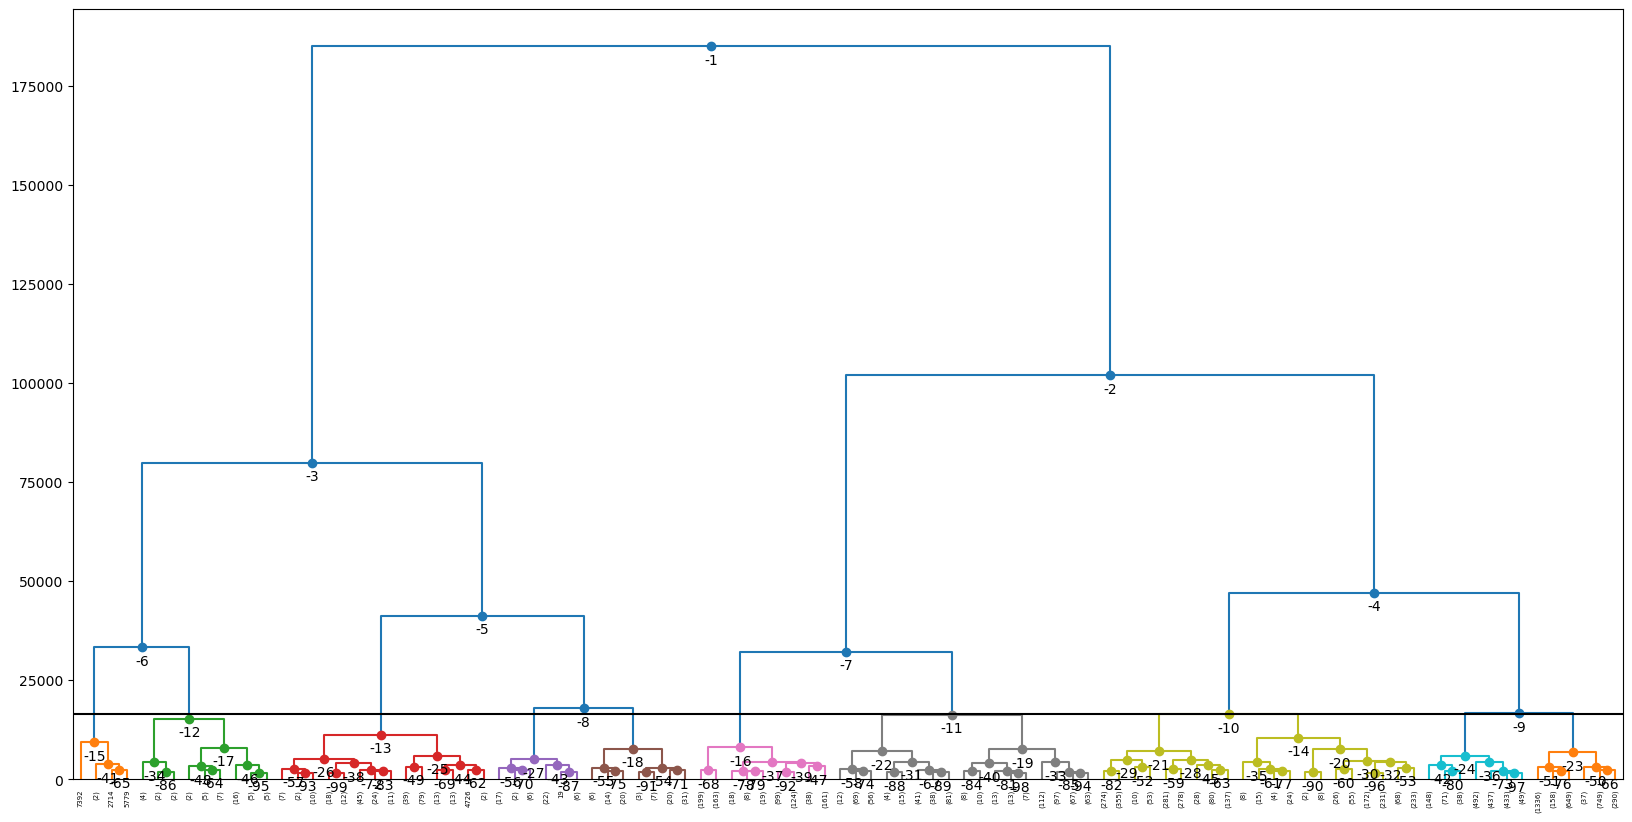

In [85]:
# Plot the dendrogram, showing ony the ast 100 merges
# and cutting the dendrogram so that we obtain 10 clusters
plot_dendrogram(Z=Z, X=X_scaled,
                truncate_mode='lastp', 
                p=100, n_clusters=10)

Here I can see some similarities betw

# Linkage method

How do we compute the distance between clusters? This is named as linkage and there are different type: 

- Single → Minimal intercluster dissimilarity. Compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the *smaller* of these dissimilarities → the shortest of the shortest distances.
    - Pros → can handle non elliptical shapes
    - Cons → sensitive to noise and outliers. Cluster tends to fuse
- Complete → Maximal intercluster dissimilarity. Compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the *largest* of these dissimilarities. Opposite to the single linkage.
    - Pros → robust to noise and outliers
    - Cons → Breaks large clusters and biased to globular cluster
- Centroid → Dissimilarities between the centroid for cluster A (a mean vector of length $p$) and the centroid for cluster B. It’s efficient because the number of centroids is equal to the number of cluster, so the computation is faster.
    - Cons → You need to be able to calculate the centroid. This is not easy with nominal attributes or strings (the average string in the cluster is not defined).
- Average → Mean intercluster dissimilarity.  Compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the *average* of these dissimilarities

Different linkage leads to different resulting clusters.

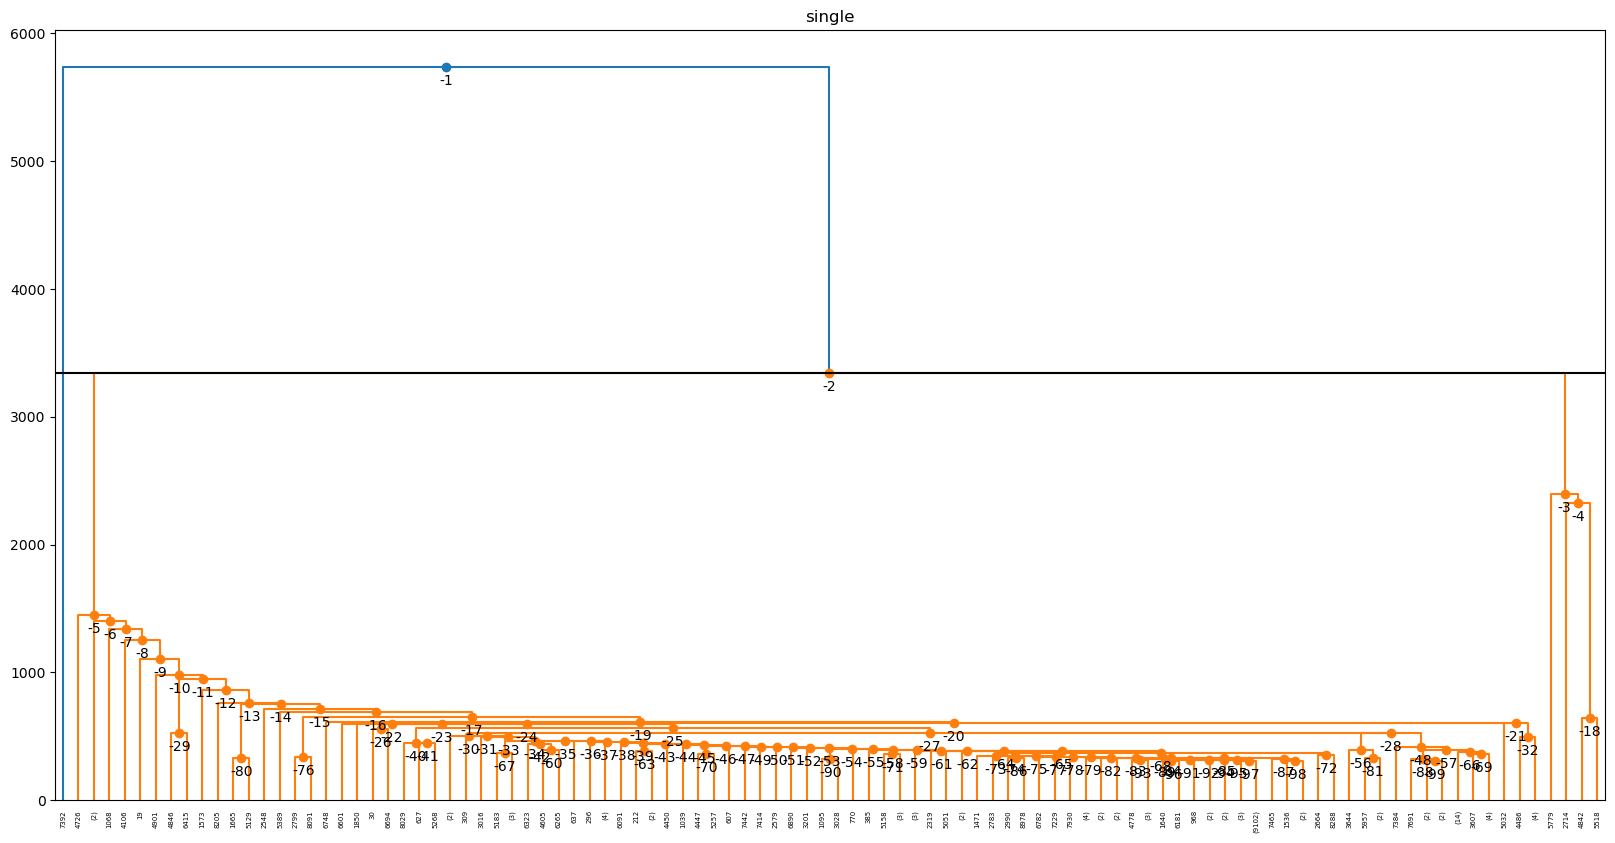

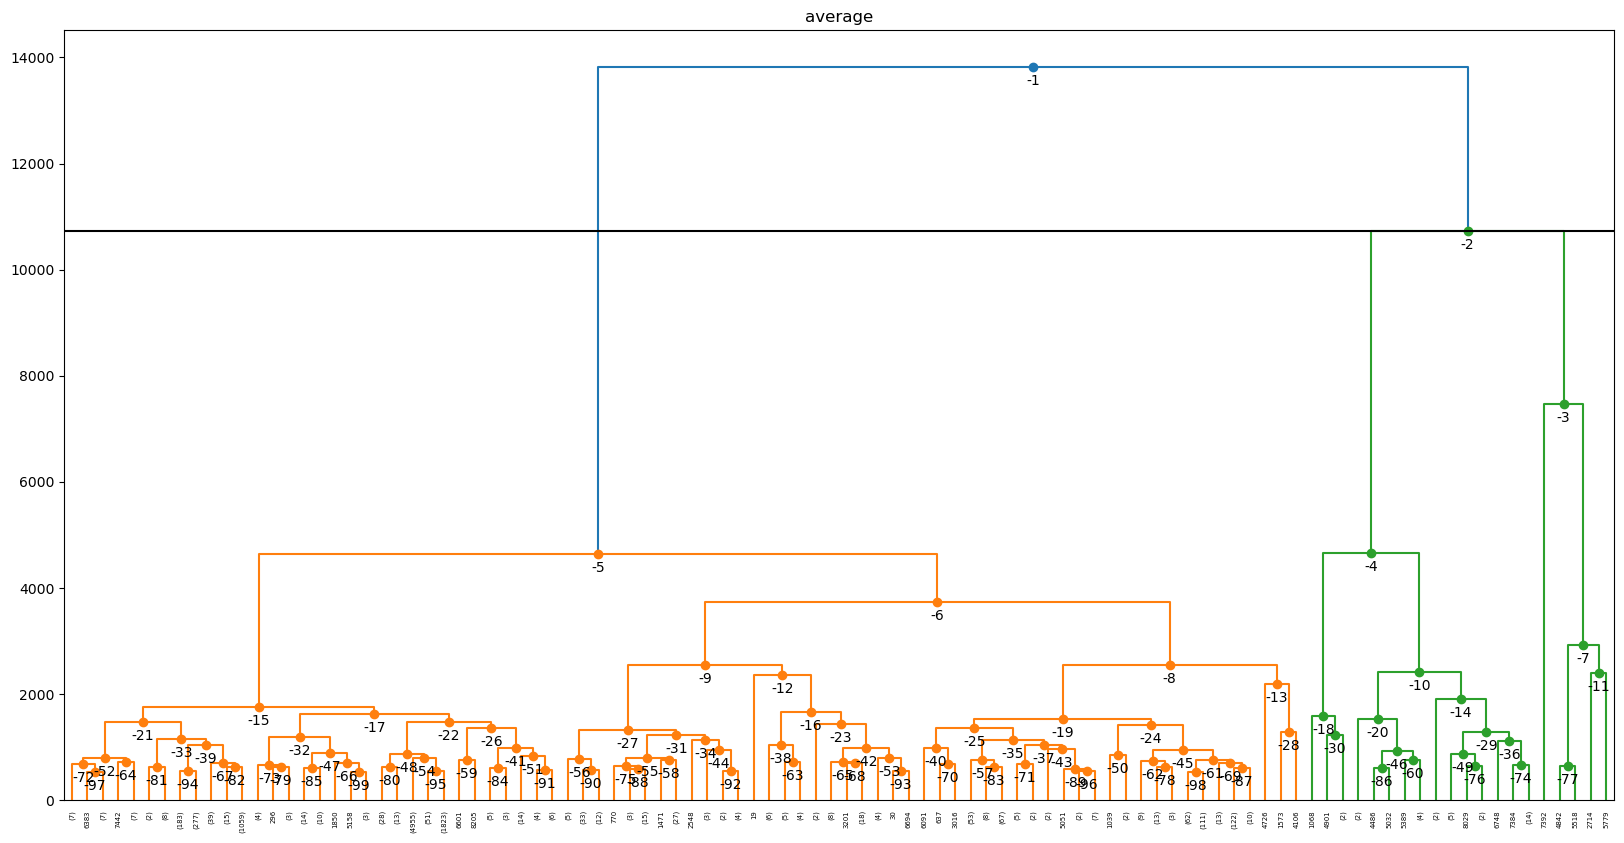

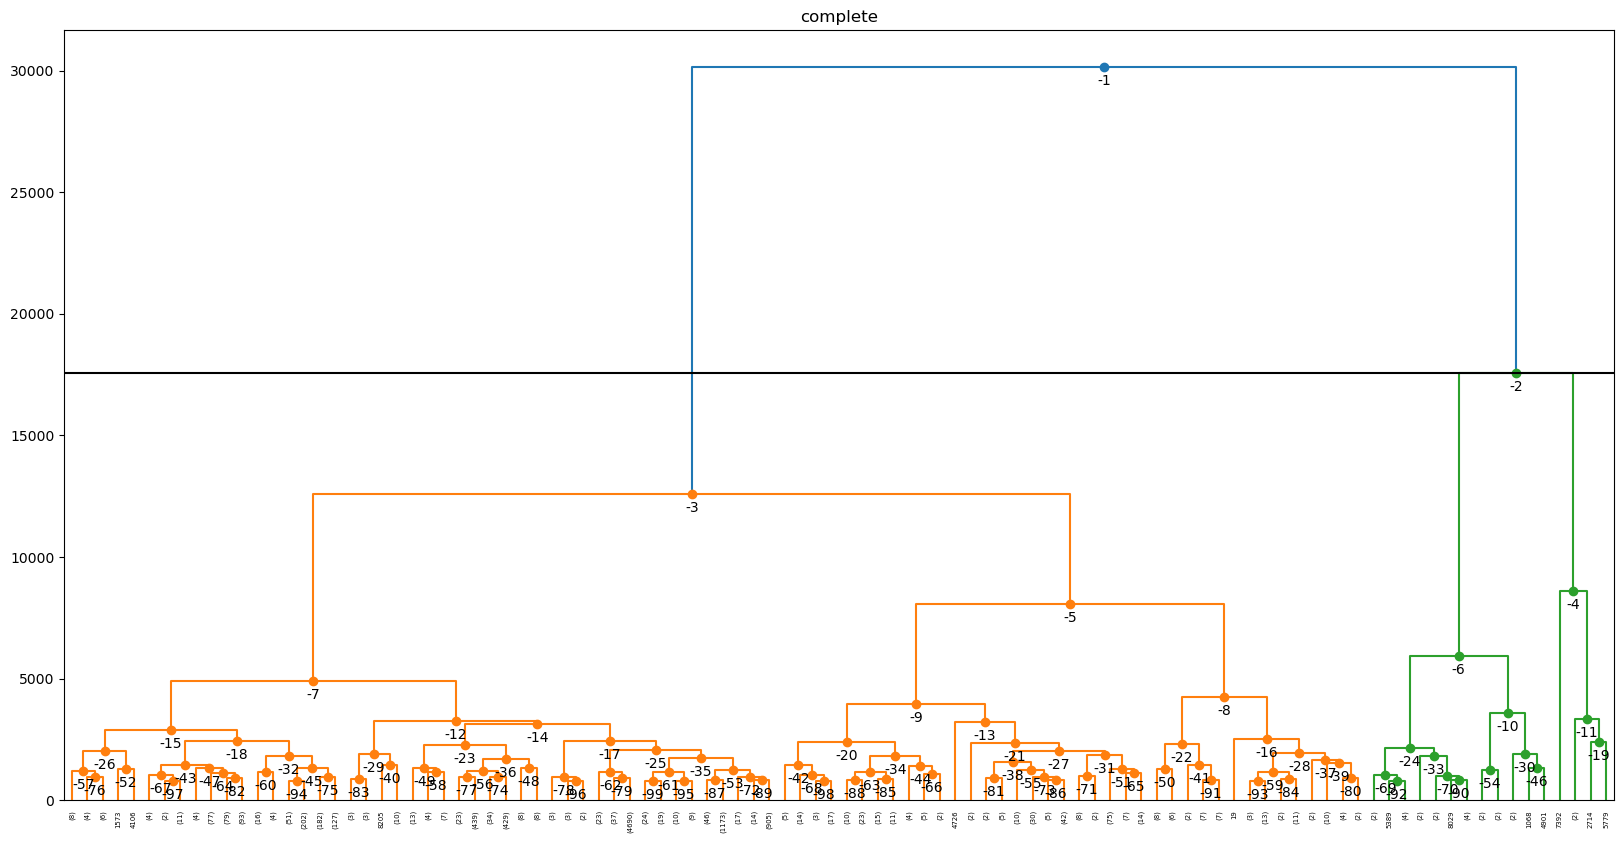

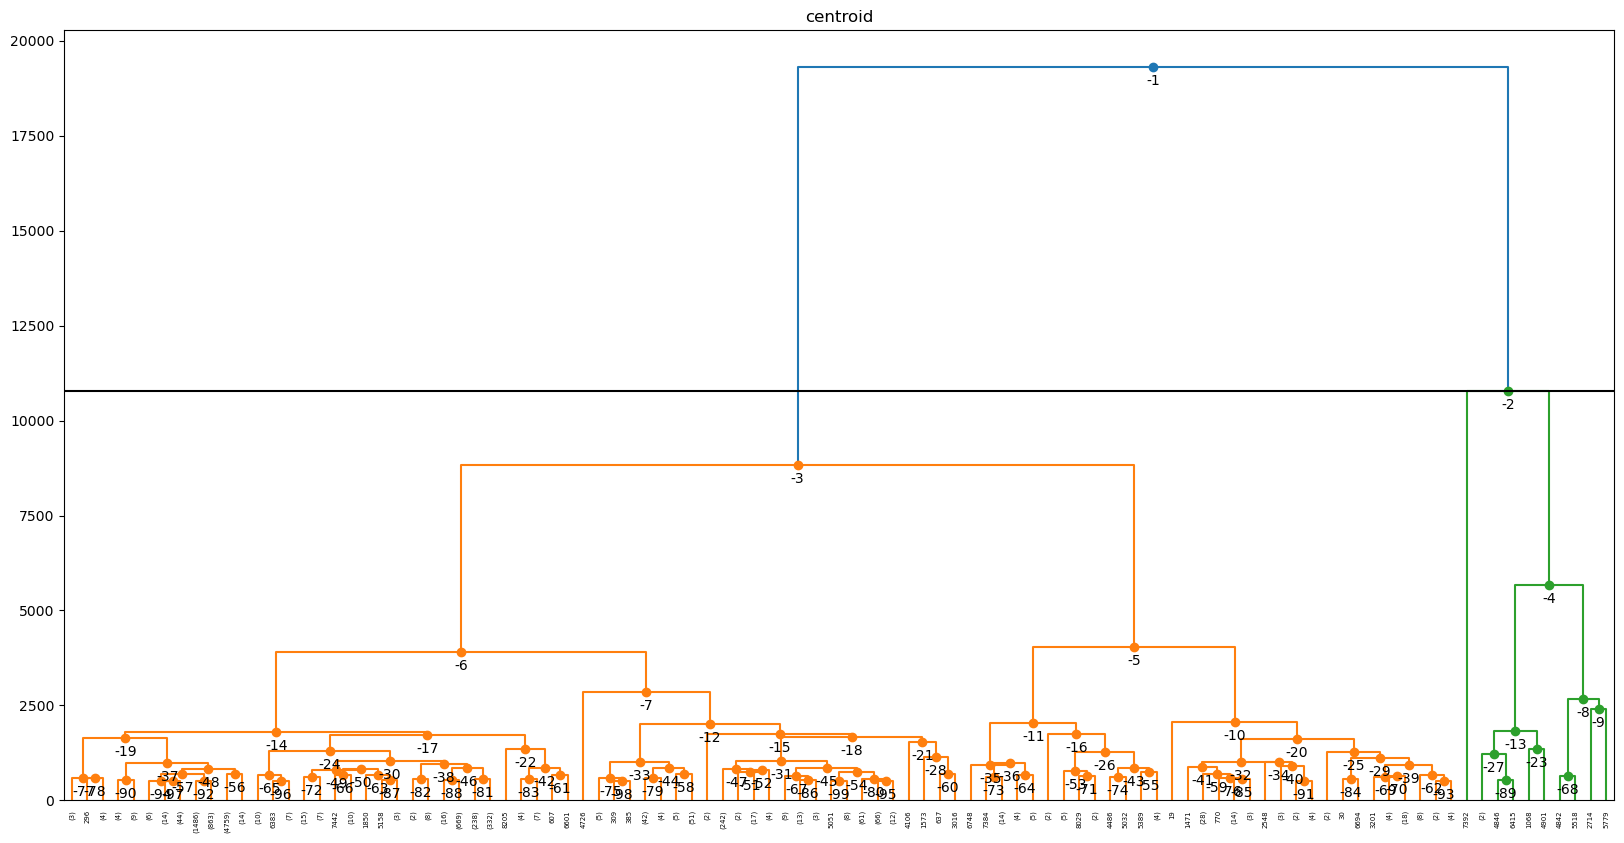

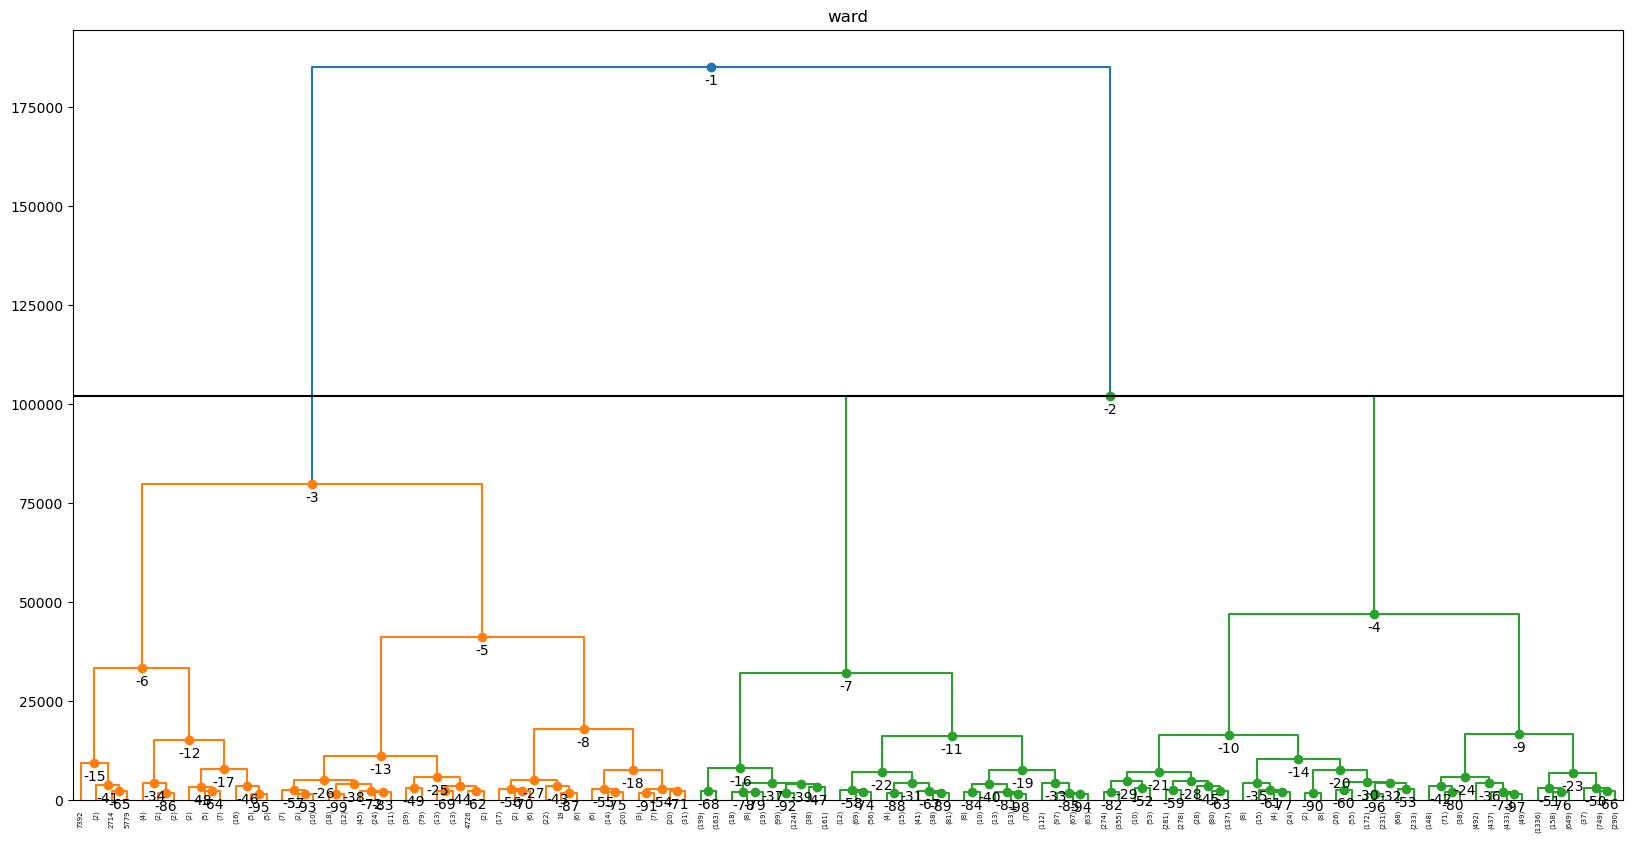

In [86]:
methods = ['single', 'average', 'complete', 'centroid', 'ward']

for method in methods:
    Z = linkage(X, method=method, metric='euclidean')
    fig, ax = plot_dendrogram(Z=Z, X=X, truncate_mode='lastp', 
                              p=100, n_clusters=2)
    ax.set_title(method)

## The AgglomerativeClustering algorithm
As usual, we can also make use of the standard scikit-learn API. It behaves similarly but also provides the the usual `fit()` and `predict()` methods.
In agglomerative clustering, the algorithm starts with each data point as its own cluster and iteratively merges the closest clusters together until all data points are grouped into a single cluster or until a specified termination condition is met. The process of merging clusters continues based on a chosen distance or similarity metric a dendrogram is formed.

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/var/folders/7x/qwmq3sh96qsdph73v_vgf3nc0000gn/T/ipykernel_8743/2624534479.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col)


(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

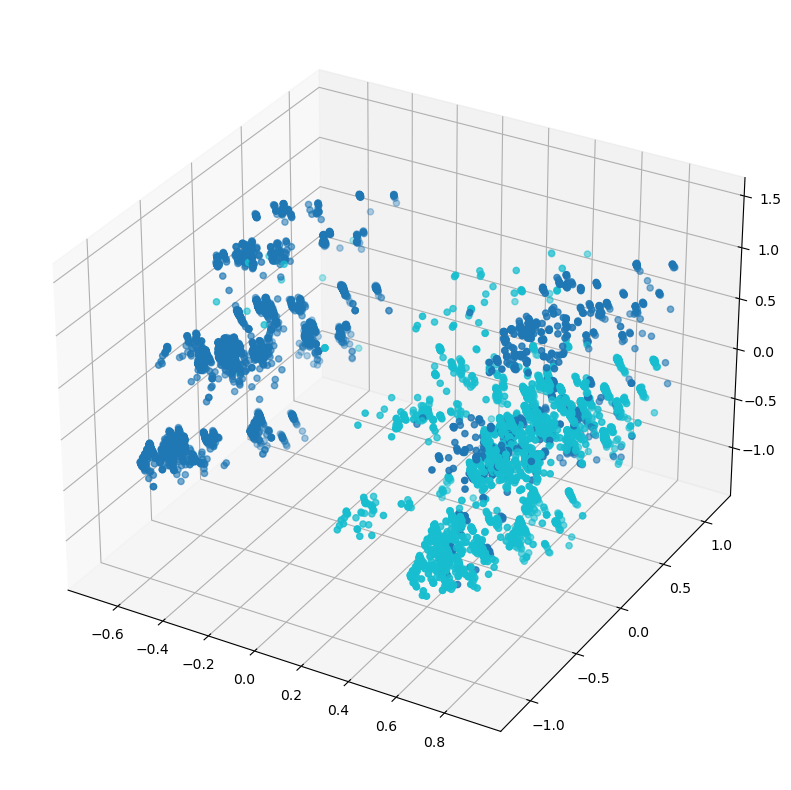

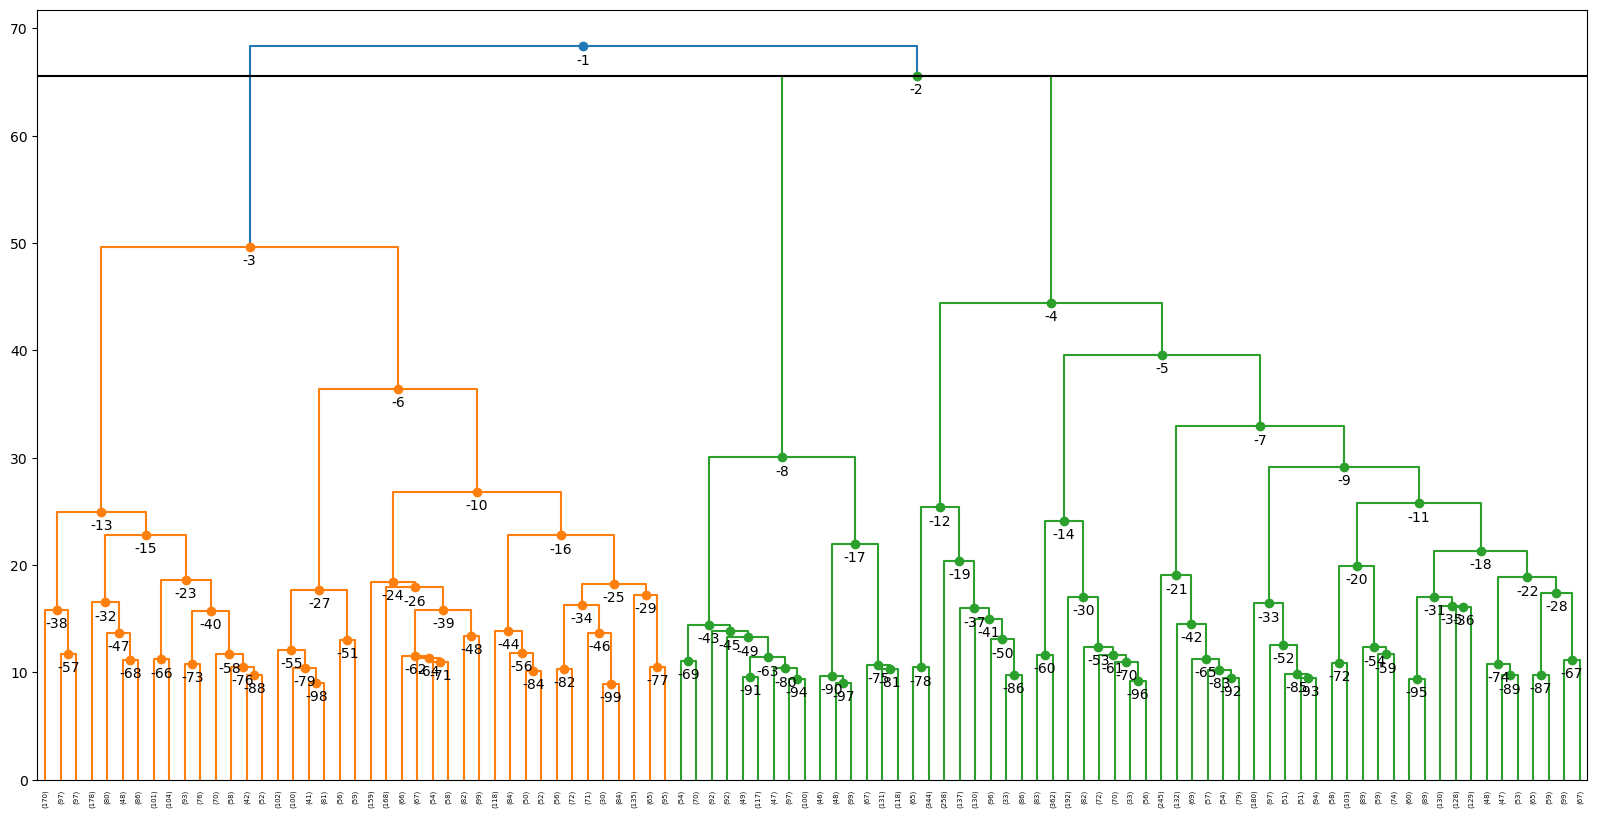

In [87]:
from sklearn.cluster import AgglomerativeClustering
distance_threshold=None
n_clusters=2

model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

y_predict = model.fit_predict(X_scaled)

plot3d(X_scaled, labels=y_predict)
plot_dendrogram(model=model, X=X_scaled, truncate_mode='lastp', p=100, 
                n_clusters=n_clusters, 
                color_threshold=distance_threshold)

In the 3d plot i obtained some sort of separation with the two classes. Note that the class imbalance is clearly visible in the dendrogram

## Clustering Metrics
to assess the validity there are correlation-based metrics that assess the similarity or dissimilarity between clusters. These metrics can provide insights into the quality and coherence of the clusters obtained from the clustering algorithm.

### Cluster validity via correlation

Define the **incidence matrix** as an $N \times N$ matrix (where N is the number of sampes) having a $1$ in position $(i, j)$ if the samples $i$ and $j$ have the same *predicted* cluster id. 

Define the **similarity matrix** as an $N \times N$ matrix containing the similarity ($1 - distance$) between each pair of points

The **clustering correlation** is defined as the correlation (normalized dot product, or cosine similairty) between these matrices, seen as two vectors!

In [88]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])
    # Retrieve how many different cluster ids there are
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]
    
    for i in range(nclusters):
        sample_idx = np.where(y_pred == i) #indices of the samples in this cluster
        # Compute combinations of these indices
        xx, yy = np.meshgrid(sample_idx, sample_idx)
        mat[xx, yy] = 1
        
    return mat

def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()
    
    # Normalize distances in [0, 1] and compute the similarity
    sim_mat = 1 - (dist_mat - min_dist) / (max_dist - min_dist)
    return sim_mat

def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)
    
    # Note: we can eventually remove duplicate values
    # only the upper/lower triangular matrix
    # triuidx = np.triu_indices(y_pred.shape[0], k=1)
    # inc = inc[triuidx]
    # sim = sim[triuidx]
    
    inc = normalize(inc.reshape(1, -1))
    sim = normalize(sim.reshape(1, -1))
    corr = inc @ sim.T
    
    return corr[0,0]

In [89]:
X_scaled.shape

(9248, 39)

In [90]:
correlation(X_scaled, y_predict, 'euclidean')

0.7581829476992237

In [91]:
y_rand = np.random.randint(0, 10, y.shape[0])
correlation(X_scaled, y_rand, 'euclidean')

0.30279687096943253

The correlation score in case of random prediction is lower while the correlation on the real data is very high.  This means that the clustering algorithm has been able to create clusters that align well with the original data patterns, resulting in highly coherent and well-defined clusters (as in the 3d plot).


## Precision, Recall and Purity
Decision, Recall, and Purity are evaluation metrics commonly used to assess the quality of clustering results. They help to measure how well the clusters represent the underlying data distribution and how distinct and pure the clusters are.

In [92]:
def get_Ncounts(y_predict, y_true, k, j=None):
    N = y_true.shape[0]
    Nk_mask = y_predict == k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    if j is not None:
        Nj_mask = y_true == j
        Nj = Nj_mask.sum()
        Nkj = np.logical_and(Nj_mask, Nk_mask).sum()
    return N, Nk, Nj, Nkj

def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)
    
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

In [93]:
tot_purity(y_predict, y)

0.8441825259497182

Only 14% of the data points are correctly clustered with all their points belonging to the same class.

## KMeans
Is one of the simplest unsupervised learning algorithms
- Assumes data lives in Euclidean space → all feature are numbers and we can compute the Euclidian distance
- Number of clusters K is known/fixed a priori → sometimes we have no clue and we need to check for each value of K.

To perform K-means clustering, we must first specify the desired number of clusters K; then the K-means algorithm will assign each observation to exactly one of the K clusters.

/Users/irenemajer/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/7x/qwmq3sh96qsdph73v_vgf3nc0000gn/T/ipykernel_8743/2624534479.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col)


Kmeans purity 0.844182525949728


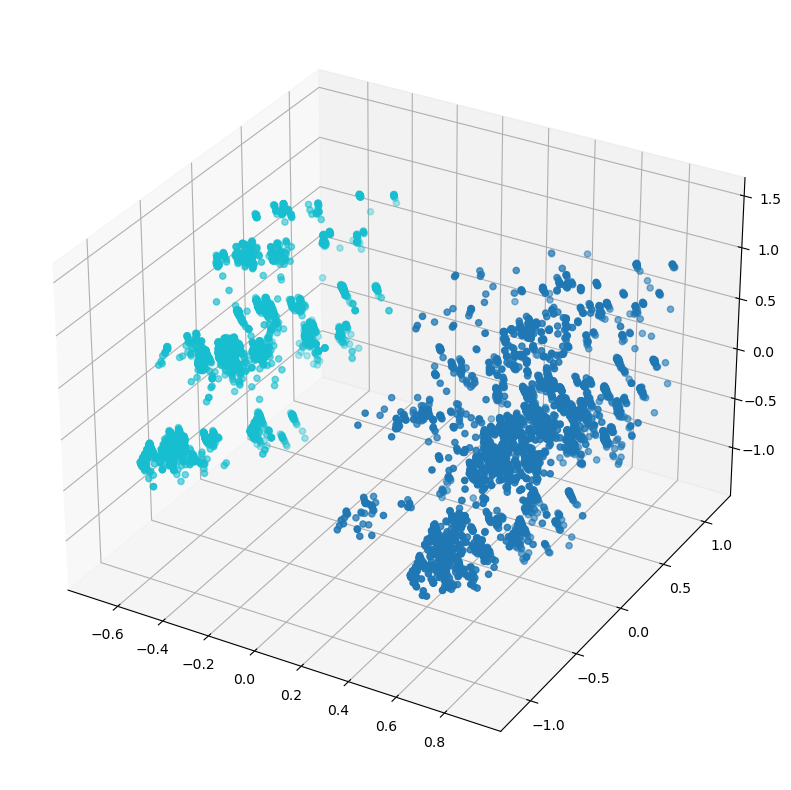

In [94]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, init='k-means++', random_state=0)   #two classes          
y_predict = model.fit_predict(X_scaled)
print("Kmeans purity", tot_purity(y_predict, y))

plot3d(X_scaled, labels=y_predict)

The data are clearly divided and I got 84% of purity. This could be a promising results but it's important to underline that k-means may be more likely to assign points to the majority class clusters, leading to a higher purity. So 84% of purity because we have 85% of points in class 0. 

## Conclusions 
At the end of this analysis, it can be concluded that satisfactory results were not achieved in the classification. The imbalance between the two classes had a significant impact on the success of various methodologies. This was consistently observed throughout the analysis. The application of K-means produced acceptable results, but it is still susceptible to the imbalance.
The application of weighted logistic regression and LDA with random forest indeed yielded quite satisfactory results as they were able to handle the aforementioned issue. It would be necessary to try more advanced methodologies such as SMOTE and XGBoost to achieve better results.